In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
from config import plot_config
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.imputation import KNNImputer
from preprocessing.outliers import replace_outliers_iqr
from utils.utils import (print_numerical_features_range, evaluate_model, evaluate_all_models)
from utils.visuals import (analyze_categorical_variables, plot_numerical_distributions, plot_correlation_heatmap, 
                           plot_outliers_analysis, plot_lambda_tuning, plot_roc_curve, plot_precision_recall_curve)
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from evaluation.cross_validation import cross_validate_lambda
from evaluation.metrics import f1_score, recall_score
from evaluation.cross_validation import stratified_cross_validate_lambda


%% Funciones Auxiliares

In [3]:
def analyze_null_values(dataframes, dataset_names=None):
    """
    Analiza y muestra información detallada sobre valores nulos en uno o más DataFrames.
    """
    from IPython.display import display
    if not isinstance(dataframes, list):
        dataframes = [dataframes]
    if dataset_names is None or len(dataset_names) != len(dataframes):
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    results = {}
    for df, name in zip(dataframes, dataset_names):
        print(f"Valores nulos en {name}:")
        null_counts = df.isnull().sum()
        total_rows = len(df)
        null_percentage = (null_counts / total_rows) * 100
        null_table = pd.DataFrame({
            'Columna': null_counts.index,
            'Cantidad de nulos': null_counts.values,
            'Porcentaje (%)': null_percentage.values.round(2)
        })
        display(null_table)
        samples_with_nulls = df.isnull().any(axis=1).sum()
        samples_without_nulls = total_rows - samples_with_nulls
        samples_percentage = (samples_with_nulls / total_rows) * 100
        summary = pd.DataFrame({
            'Métrica': ['Muestras con al menos un valor nulo', 'Muestras sin valores nulos', 'Total de muestras'],
            'Cantidad': [samples_with_nulls, samples_without_nulls, total_rows],
            'Porcentaje (%)': [samples_percentage.round(2), (100 - samples_percentage).round(2), 100.0]
        })
        display(summary)
        results[name] = {
            'null_table': null_table,
            'summary': summary,
            'total_nulls': null_counts.sum(),
            'total_rows': total_rows,
            'null_percentage': (null_counts.sum() / (total_rows * len(df.columns)) * 100).round(2)
        }
        print("\n")
    return results

In [4]:
def train_valid_split(df, test_size=0.2, random_state=42):
    """
    Divide un DataFrame en conjuntos de entrenamiento y validación.
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_size)
    valid_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[valid_indices]

In [5]:
def impute_missing_values(train_df, valid_df=None, test_df=None, knn_neighbors=8, knn_weights='distance'):
    """
    Imputa valores faltantes utilizando un KNNImputer personalizado.
    """
    # Resetear índices
    train_df = train_df.reset_index(drop=True)
    if valid_df is not None:
        valid_df = valid_df.reset_index(drop=True)
    if test_df is not None:
        test_df = test_df.reset_index(drop=True)
    
    print("Missing values before imputation:")
    print(f"Train: {train_df.isna().sum().sum()} missing values")
    if valid_df is not None:
        print(f"Valid: {valid_df.isna().sum().sum()} missing values")
    if test_df is not None:
        print(f"Test: {test_df.isna().sum().sum()} missing values")
    
    custom_imputer = KNNImputer(n_neighbors=knn_neighbors, weights=knn_weights, return_df=True)
    custom_imputer.fit(train_df)
    
    imputed_train = custom_imputer.transform(train_df)
    imputed_valid = custom_imputer.transform(valid_df) if valid_df is not None else None
    imputed_test = custom_imputer.transform(test_df) if test_df is not None else None
    
    print("\nMissing values after imputation:")
    print(f"Train: {imputed_train.isna().sum().sum()} missing values")
    if imputed_valid is not None:
        print(f"Valid: {imputed_valid.isna().sum().sum()} missing values")
    if imputed_test is not None:
        print(f"Test: {imputed_test.isna().sum().sum()} missing values")
    
    result = [imputed_train]
    if valid_df is not None:
        result.append(imputed_valid)
    if test_df is not None:
        result.append(imputed_test)
    return tuple(result) if len(result) > 1 else result[0]

In [6]:
def apply_feature_engineering(df, transformations, inplace=False, verbose=False):
    """
    Aplica transformaciones de feature engineering a un DataFrame.
    """
    if not inplace:
        df = df.copy()
    for new_feature, transform_func in transformations.items():
        if verbose:
            print(f"Aplicando transformación para la feature: '{new_feature}'")
        df[new_feature] = transform_func(df)
    return df

%% Configuración de Directorios y Variables Globales

In [7]:
fig_output_dir_p1 = "./figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)
current_dir = Path.cwd()
data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve()
data_dir_p1 = data_dir / "p1"

# Punto 1.1: Inicialización del Dataset

In [8]:
config_cell_diagnosis = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis = DataLoader(config_cell_diagnosis)
loader_cell_diagnosis.load_data(
    dev_file="raw/cell_diagnosis_balanced_dev.csv",
    test_file="raw/cell_diagnosis_balanced_test.csv",
    splitted=False
)
cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=False)

%% Análisis de Valores Nulos y División Train/Valid

In [9]:
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers = train_valid_split(
    cell_diagnosis_balanced_dev_outliers, test_size=0.2, random_state=12
)
analyze_null_values(
    [cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_test_outliers],
    ["conjunto de train", "conjunto de prueba"]
);

Valores nulos en conjunto de train:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                258           19.38
1             CellShape                253           19.01
2        NucleusDensity                235           17.66
3      ChromatinTexture                240           18.03
4         CytoplasmSize                245           18.41
5          CellAdhesion                234           17.58
6           MitosisRate                261           19.61
7       NuclearMembrane                248           18.63
8          GrowthFactor                239           17.96
9      OxygenSaturation                229           17.21
10      Vascularization                246           18.48
11  InflammationMarkers                252           18.93
12            Diagnosis                  0            0.00
13             CellType                202           15.18
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1228           92.26
1           Muestras sin valores nulos       103            7.74
2                    Total de muestras      1331          100.00



Valores nulos en conjunto de prueba:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 35           18.92
1             CellShape                 41           22.16
2        NucleusDensity                 32           17.30
3      ChromatinTexture                 35           18.92
4         CytoplasmSize                 33           17.84
5          CellAdhesion                 29           15.68
6           MitosisRate                 36           19.46
7       NuclearMembrane                 25           13.51
8          GrowthFactor                 40           21.62
9      OxygenSaturation                 31           16.76
10      Vascularization                 40           21.62
11  InflammationMarkers                 36           19.46
12            Diagnosis                  0            0.00
13             CellType                 31           16.76
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       172           92.97
1           Muestras sin valores nulos        13            7.03
2                    Total de muestras       185          100.00

%% Imputación de Valores Faltantes

In [10]:
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = impute_missing_values(
    cell_diagnosis_balanced_train_outliers,
    cell_diagnosis_balanced_valid_outliers,
    cell_diagnosis_balanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

Missing values before imputation:
Train: 3142 missing values
Valid: 821 missing values
Test: 444 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


%% Actualización y Guardado de Datos Preprocesados

In [11]:
def save_processed_data(loader, data_dict, data_dir, dataset_name, processing_type="preprocessed"):
    """
    Guarda los datos procesados o preprocesados en archivos CSV.
    
    Args:
        loader: Instancia del DataLoader
        data_dict: Diccionario con los DataFrames a guardar
        data_dir: Directorio base de datos
        dataset_name: Nombre del conjunto de datos
        processing_type: Tipo de procesamiento ("preprocessed" o "processed")
    """
    # Actualizar el loader con los nuevos datos
    loader.update(**data_dict)
    
    # Construir las rutas de los archivos
    base_path = data_dir / "p1" / processing_type
    
    # Crear directorio si no existe
    base_path.mkdir(parents=True, exist_ok=True)
    
    # Construir rutas completas
    file_paths = {
        'train': base_path / f"{dataset_name}_train.csv",
        'valid': base_path / f"{dataset_name}_valid.csv",
        'test': base_path / f"{dataset_name}_test.csv",
        'dev': base_path / f"{dataset_name}_dev.csv" if 'dev' in data_dict else None
    }
    
    # Guardar los datos
    loader.save_processed_data(
        df_train_dir=file_paths['train'],
        df_valid_dir=file_paths['valid'],
        df_test_dir=file_paths['test'],
        df_dev_dir=file_paths['dev'] if 'dev' in file_paths else None
    )

# Uso de la función
data_dict = {
    'df_train': cell_diagnosis_balanced_train_outliers,
    'df_valid': cell_diagnosis_balanced_valid_outliers,
    'df_test': cell_diagnosis_balanced_test_outliers
}

save_processed_data(
    loader=loader_cell_diagnosis,
    data_dict=data_dict,
    data_dir=data_dir,
    dataset_name="cell_diagnosis_balanced",
    processing_type="preprocessed"
)

%% Recarga de Datos Preprocesados

In [12]:
loader_cell_diagnosis.load_data(
    train_file="preprocessed/cell_diagnosis_balanced_train.csv",
    valid_file="preprocessed/cell_diagnosis_balanced_valid.csv",
    test_file="preprocessed/cell_diagnosis_balanced_test.csv",
    splitted=True
)
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=True)

%% Análisis de Rango de Features

In [13]:
print_numerical_features_range(cell_diagnosis_balanced_train_outliers)

Feature    Mínimo     Máximo
0              CellSize -100.0000  1000.0000
1             CellShape   -1.4130     4.9121
2        NucleusDensity   -3.0000    50.0000
3      ChromatinTexture   15.7767   229.1848
4         CytoplasmSize    5.0000   299.3506
5          CellAdhesion   -4.4618     5.0299
6           MitosisRate  -50.0000   100.0000
7       NuclearMembrane   -1.1124    24.8718
8          GrowthFactor  -50.0000   563.6227
9      OxygenSaturation  -10.0000   807.1811
10      Vascularization   -0.9971    54.5124
11  InflammationMarkers    0.0000   440.9023
12            Diagnosis    0.0000     1.0000

%% Análisis Exploratorio y Visualizaciones

In [14]:
analyze_categorical_variables(cell_diagnosis_balanced_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"])

Categorical variables distribution:

CellType distribution:


CellType  Count  Percentage (%)
0         ???    597           44.85
1    Epthlial    380           28.55
2  Mesnchymal    354           26.60


GeneticMutation distribution:


GeneticMutation  Count  Percentage (%)
0          Presnt    690           51.84
1           Absnt    641           48.16


Diagnosis distribution:


Diagnosis  Count  Percentage (%)
0        0.0    738           55.45
1        1.0    593           44.55

In [15]:
exclude_columns = ["Diagnosis"]
numerical_cols_cell_diagnosis_balanced_train_outliers = cell_diagnosis_balanced_train_outliers.select_dtypes(include=["number"]).columns.tolist()
numerical_cols_cell_diagnosis_balanced_train_outliers = [
    col for col in numerical_cols_cell_diagnosis_balanced_train_outliers if col not in exclude_columns
]
FEATURES_TO_PLOT = ["CellSize", "MitosisRate", "NucleusDensity"]

Saved figure to figures/numerical_distributions_outliers.png


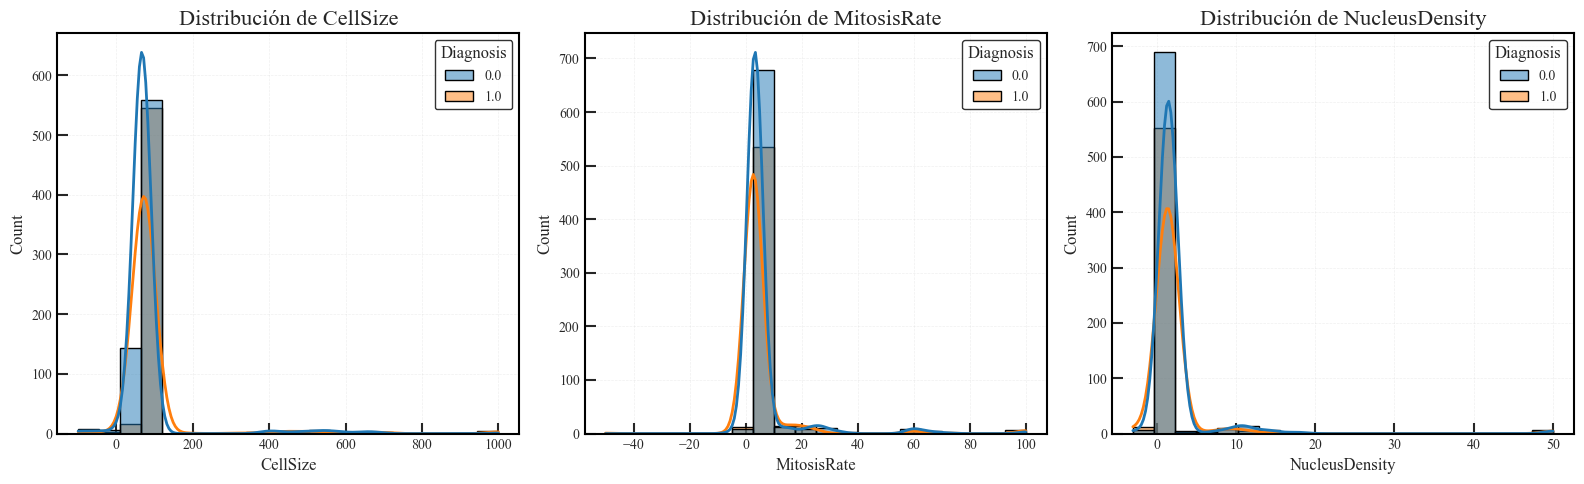

In [16]:
fig = plot_numerical_distributions(
    cell_diagnosis_balanced_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    features_to_plot=FEATURES_TO_PLOT,
    figsize=(16, 5),
    output_dir="figures",
    filename="numerical_distributions_outliers.png"
)
plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_outliers.png


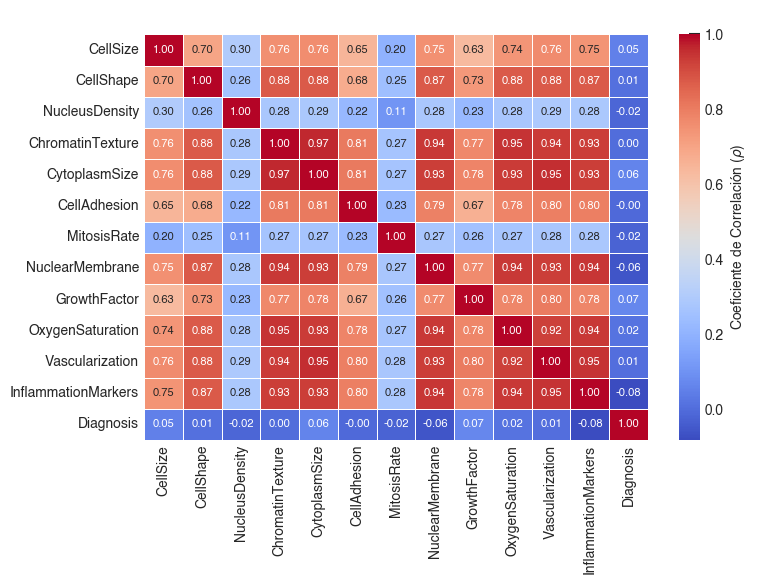

In [17]:
fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_outliers.png",
    title=" ",
    figsize=(8, 6)
)
plt.show()

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


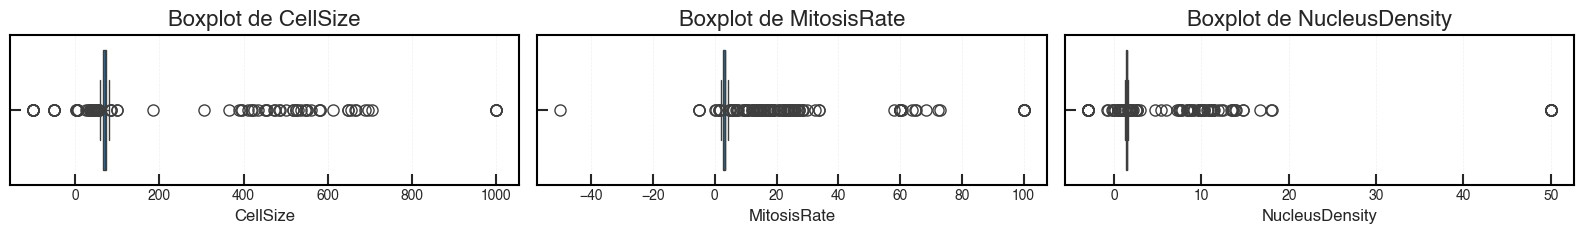

In [18]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_train_outliers,
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    filename="boxplots_outliers_analysis.png",
    figsize=(16, 5),
    show_plots=True
)

%% Reemplazo de Outliers

In [19]:
cell_diagnosis_balanced_train, params = replace_outliers_iqr(
    cell_diagnosis_balanced_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_balanced_valid = replace_outliers_iqr(
    cell_diagnosis_balanced_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_balanced_test = replace_outliers_iqr(
    cell_diagnosis_balanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)

In [20]:
# Crear el conjunto de desarrollo combinando train y valid
cell_diagnosis_balanced_dev = pd.concat([cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid])

# Actualizar el loader con los datos procesados
loader_cell_diagnosis.update(
    df_train=cell_diagnosis_balanced_train,
    df_valid=cell_diagnosis_balanced_valid,
    df_test=cell_diagnosis_balanced_test
)

data_dict = {
    'df_train': cell_diagnosis_balanced_train,
    'df_valid': cell_diagnosis_balanced_valid,
    'df_test': cell_diagnosis_balanced_test,
    'df_dev': cell_diagnosis_balanced_dev
}

save_processed_data(
    loader=loader_cell_diagnosis,
    data_dict=data_dict,
    data_dir=data_dir,
    dataset_name="cell_diagnosis_balanced",
    processing_type="processed"
)

In [21]:

loader_cell_diagnosis.load_data(
    train_file="processed/cell_diagnosis_balanced_train.csv",
    valid_file="processed/cell_diagnosis_balanced_valid.csv",
    test_file="processed/cell_diagnosis_balanced_test.csv",
    splitted=True
)
cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid, cell_diagnosis_balanced_test = loader_cell_diagnosis.get_pandas_data(splitted=True)


In [22]:
print_numerical_features_range(cell_diagnosis_balanced_valid)


Feature   Mínimo   Máximo
0              CellSize  57.6812  81.5172
1             CellShape   0.4285   0.5739
2        NucleusDensity   1.2642   1.6212
3      ChromatinTexture  19.3019  24.8079
4         CytoplasmSize  20.4988  36.3413
5          CellAdhesion   0.4116   0.5412
6           MitosisRate   1.8389   4.3878
7       NuclearMembrane   1.8528   2.9358
8          GrowthFactor  50.5599  70.3781
9      OxygenSaturation  76.5477  83.6431
10      Vascularization   4.0558   6.0429
11  InflammationMarkers  28.1420  53.2164
12            Diagnosis   0.0000   1.0000

Saved figure to figures/numerical_distributions.png


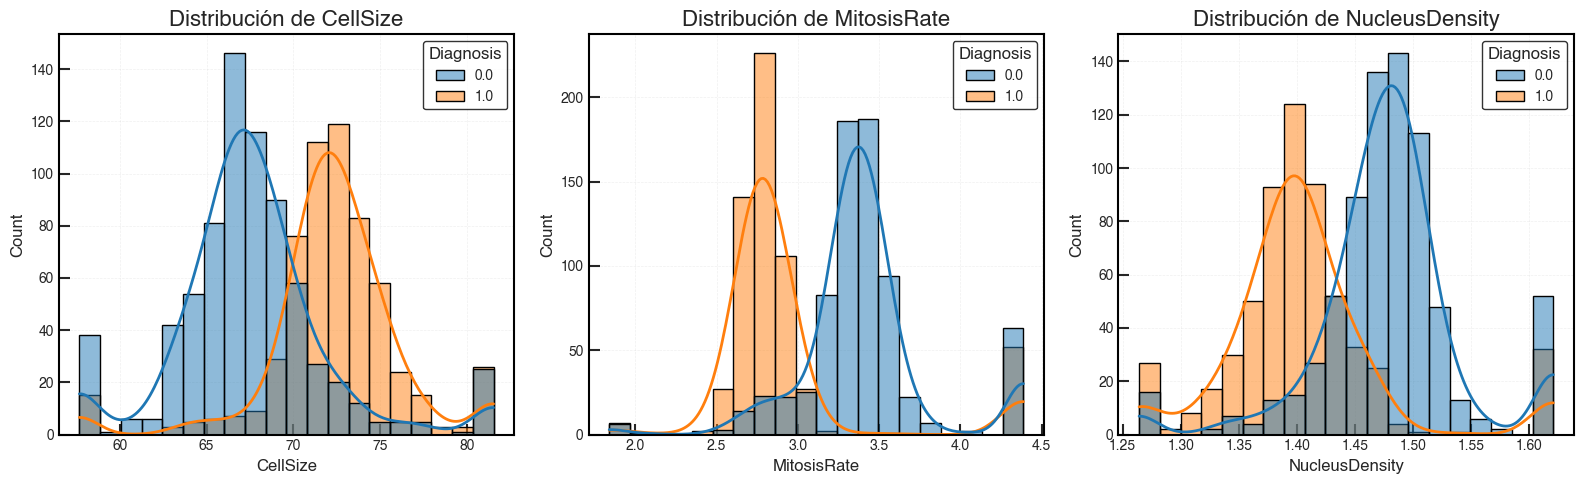

In [23]:
fig = plot_numerical_distributions(
    cell_diagnosis_balanced_train,
    numerical_cols=numerical_cols_cell_diagnosis_balanced_train_outliers,
    features_to_plot=FEATURES_TO_PLOT,
    target_column="Diagnosis",
    output_dir="figures",
    filename="numerical_distributions.png",
    figsize=(16, 5)
)
plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features.png


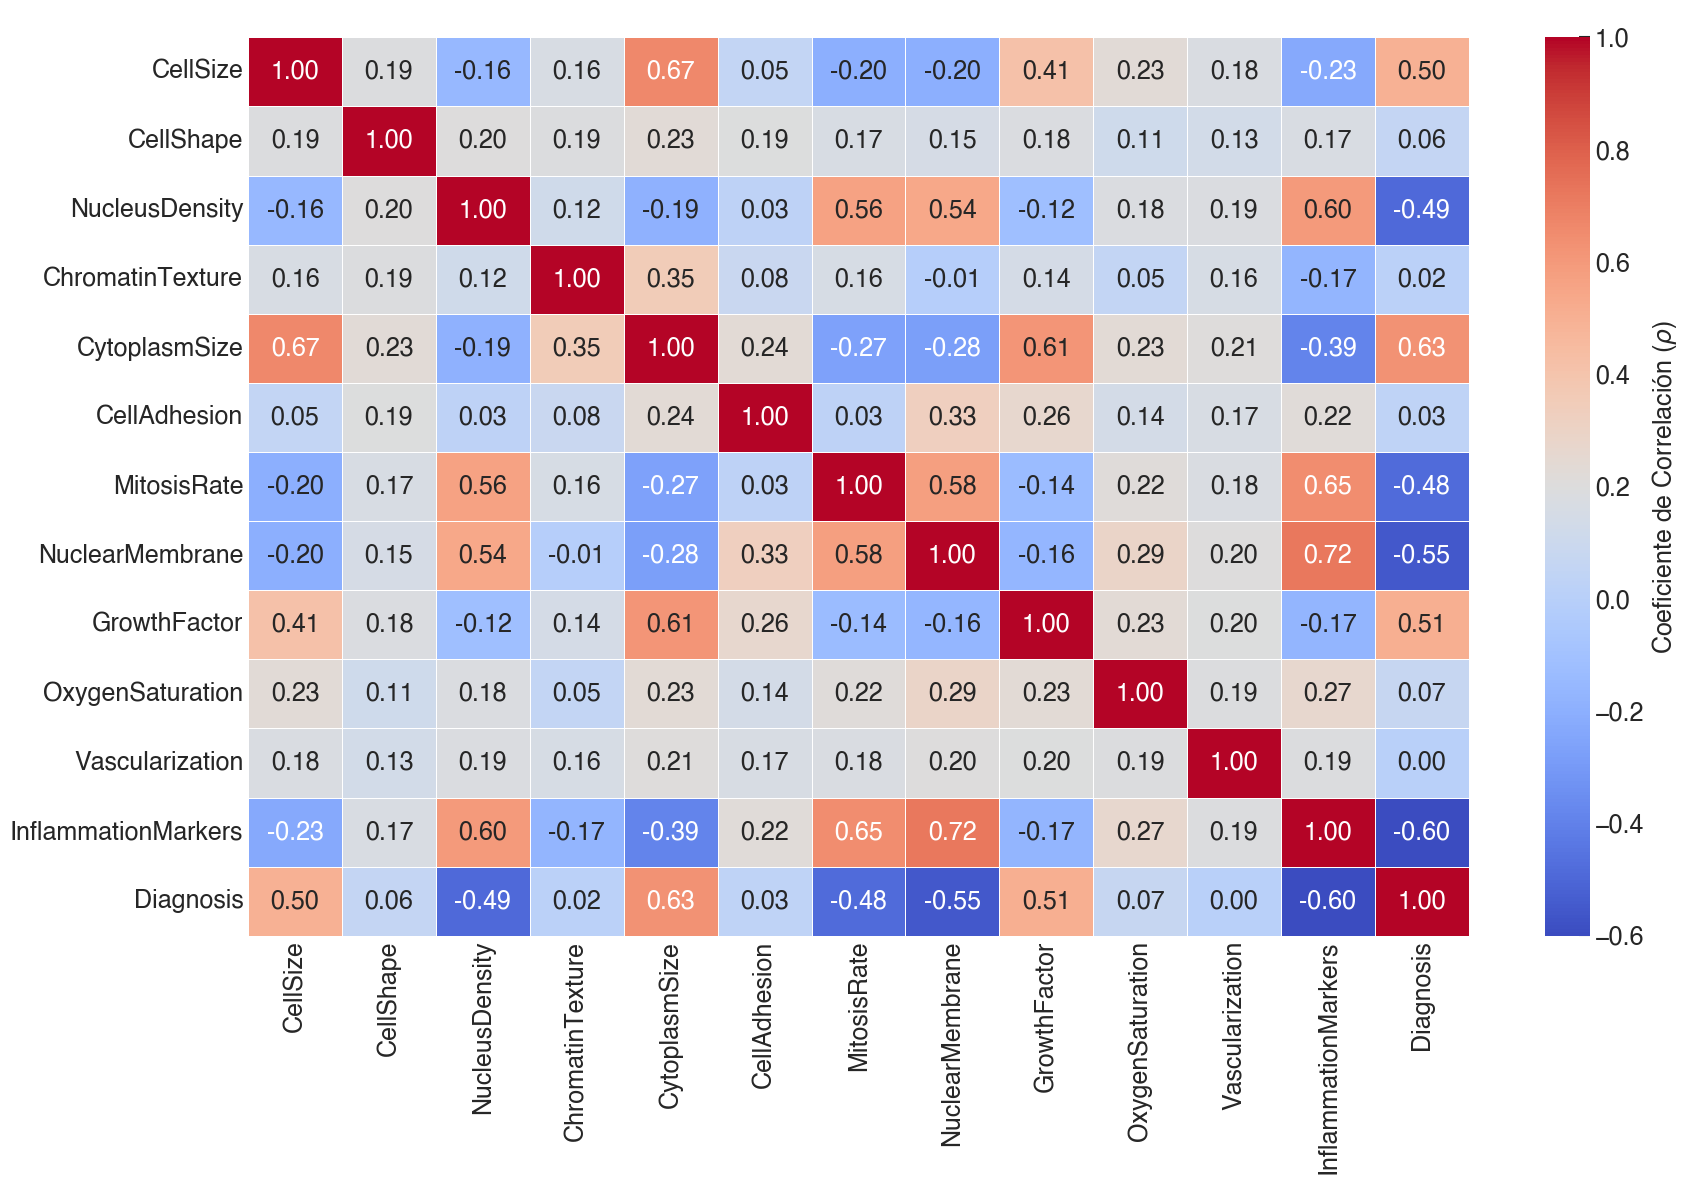

In [24]:
fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_train,
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features.png",
    title=" ",
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18, 12)
)
plt.show()

Gráfico guardado en: ./figures/p1/boxplots_analysis.png


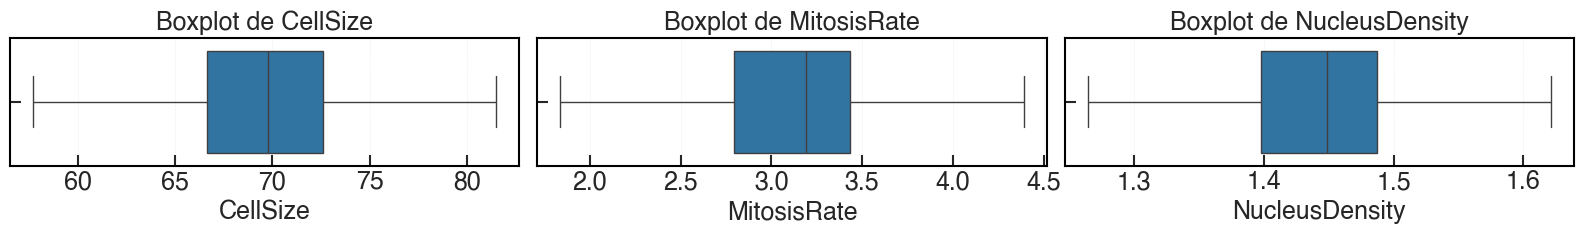

In [25]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_train,
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename="boxplots_analysis.png",
    show_plots=True
)

# Punto 1.2: Modelado con Regresión Logística - Feature Engineering

In [26]:
transformations = {
    "Nucleus_Cytoplasm_Ratio": lambda d: (d["CellSize"] - d["CytoplasmSize"]) / d["CytoplasmSize"],
    "ProliferationIndex": lambda d: d["GrowthFactor"] * d["MitosisRate"],
    "DensityTextureIndex": lambda d: d["NucleusDensity"] * d["ChromatinTexture"],
}
cell_diagnosis_balanced_train = apply_feature_engineering(cell_diagnosis_balanced_train, transformations, verbose=False)
cell_diagnosis_balanced_valid = apply_feature_engineering(cell_diagnosis_balanced_valid, transformations, verbose=False)
cell_diagnosis_balanced_test = apply_feature_engineering(cell_diagnosis_balanced_test, transformations, verbose=False)

%% Cross Validation para Optimización de Lambda

In [27]:
X_train_cell_diagnosis = cell_diagnosis_balanced_train.drop(columns=["Diagnosis"])
y_train_cell_diagnosis = cell_diagnosis_balanced_train["Diagnosis"]

In [28]:
X_train_cell_diagnosis = DataLoader.encode_categorical(X_train_cell_diagnosis)
X_train_cell_diagnosis, y_train_cell_diagnosis = X_train_cell_diagnosis.to_numpy(), y_train_cell_diagnosis.to_numpy()

In [29]:
lambda_values = np.concatenate([
    np.logspace(-6, -3, 50),
    np.logspace(-3, 1, 200)
])

In [30]:
best_lambda, mean_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis,
    y=y_train_cell_diagnosis,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2
)

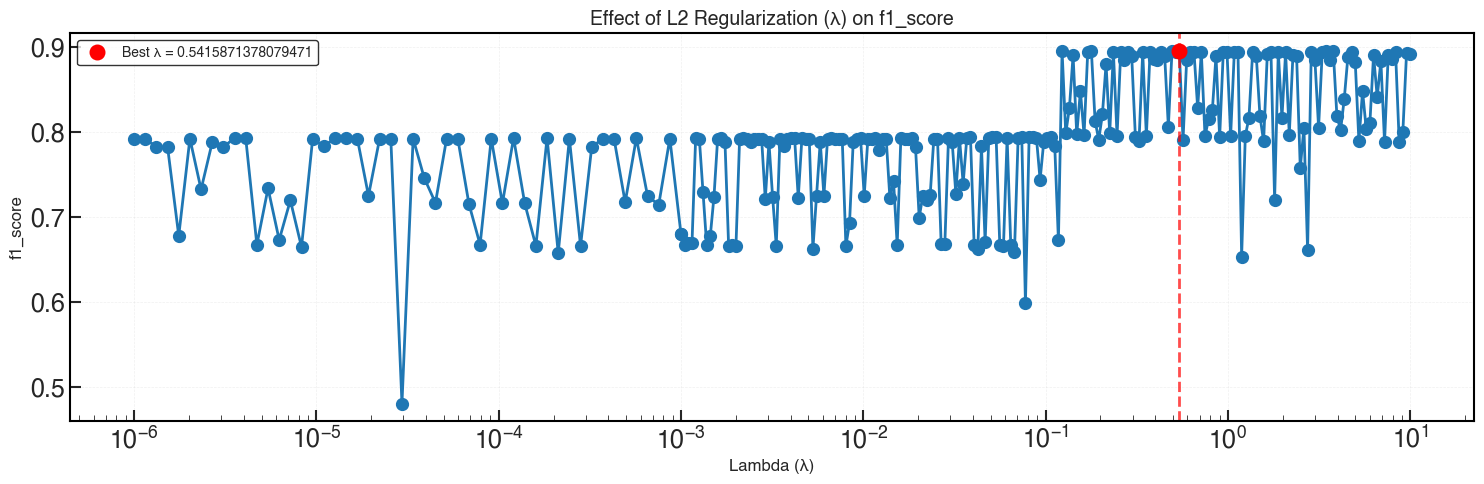

Optimal lambda value: 0.5415871378079471


In [31]:
plot_lambda_tuning(
    lambda_values=lambda_values,
    scores=mean_scores,
    metric_name=f1_score.__name__,
    best_lambda=best_lambda,
    figsize=(15, 5)
)
plt.show()
print(f"Optimal lambda value: {best_lambda}")

%% Entrenamiento Final y Evaluación en Conjunto de Validación

In [32]:
final_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda
)
X_valid_cell_diagnosis = cell_diagnosis_balanced_valid.drop(columns=["Diagnosis"])
y_valid_cell_diagnosis = cell_diagnosis_balanced_valid["Diagnosis"]


In [33]:
X_valid_cell_diagnosis = DataLoader.encode_categorical(X_valid_cell_diagnosis)
X_valid_cell_diagnosis, y_valid_cell_diagnosis = X_valid_cell_diagnosis.to_numpy(), y_valid_cell_diagnosis.to_numpy()

In [34]:
final_model = LogisticRegression(final_config)
final_model.fit(X_train_cell_diagnosis, y_train_cell_diagnosis);

Accuracy: 0.9096
Precision: 0.8889
Recall: 0.9231
F1 Score: 0.9057


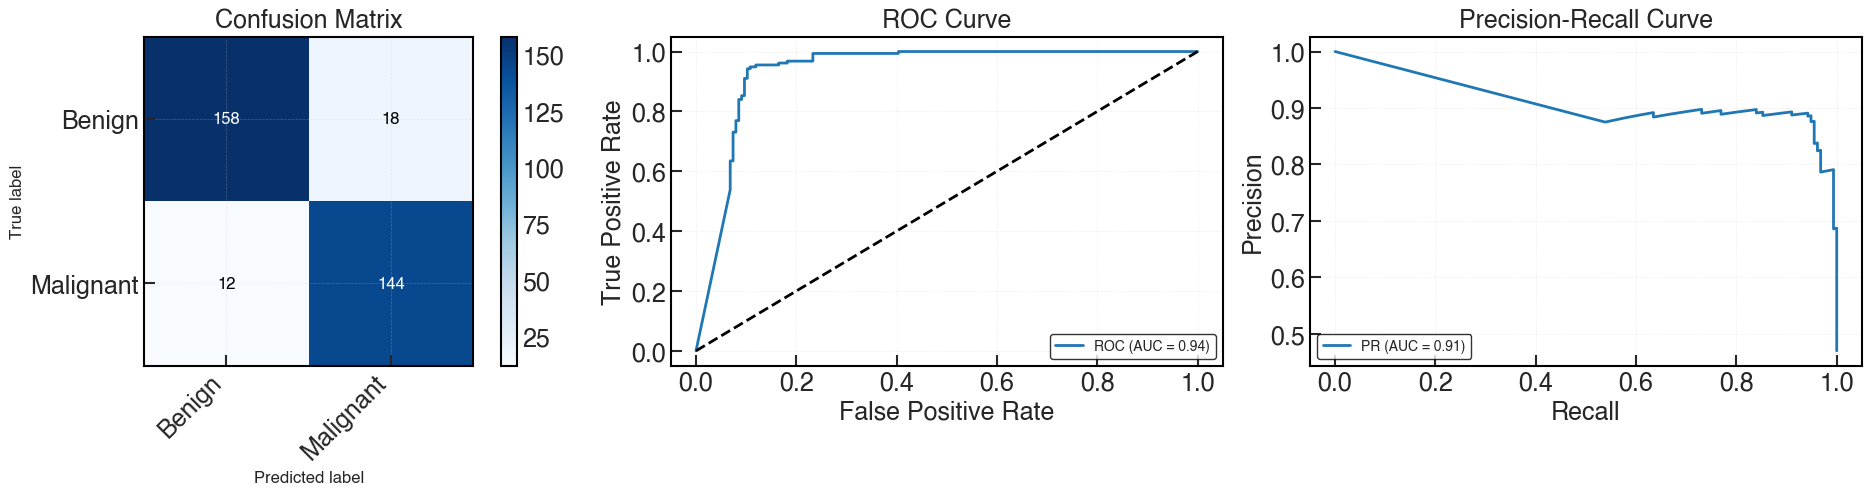

In [35]:
results = evaluate_model(
    threshold=0.2,
    model=final_model,
    X_test=X_valid_cell_diagnosis,
    y_test=y_valid_cell_diagnosis,
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1,
    figsize=(20, 5),
    base_filename="test_balanced"
)

# Punto 1.3: Evaluación en Conjunto de Test Final

In [36]:
X_final_test = cell_diagnosis_balanced_test.drop(columns=["Diagnosis"])
y_final_test = cell_diagnosis_balanced_test["Diagnosis"]

In [37]:
X_final_test = DataLoader.encode_categorical(X_final_test)
X_final_test, y_final_test = X_final_test.to_numpy(), y_final_test.to_numpy()

Accuracy: 0.9243
Precision: 0.9259
Recall: 0.9036
F1 Score: 0.9146


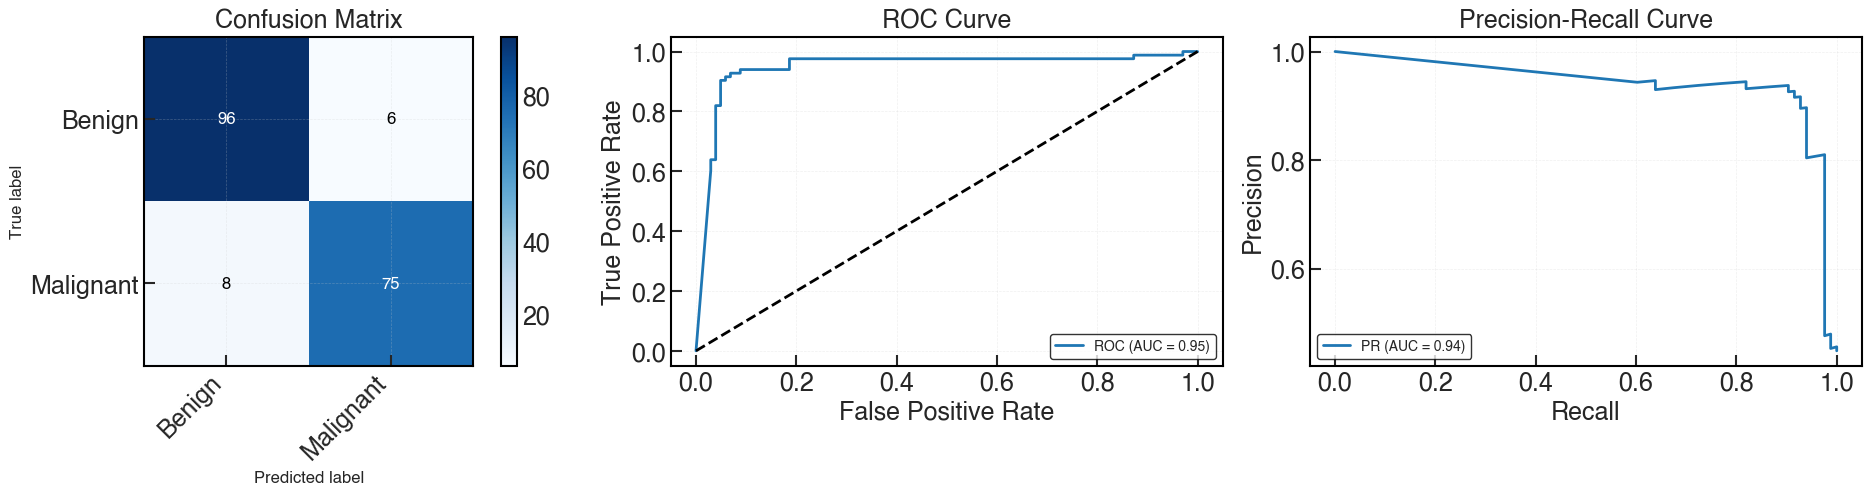

In [38]:
results = evaluate_model(
    model=final_model,
    X_test=X_final_test,
    y_test=y_final_test,
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1,
    figsize=(20, 5),
    base_filename="test_balanced"
)

# Punto 1.4: Datos Desbalanceados - Carga y Preprocesamiento

In [39]:
config_cell_diagnosis_imbalanced = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis_imbalanced = DataLoader(config_cell_diagnosis_imbalanced)
loader_cell_diagnosis_imbalanced.load_data(
    dev_file="raw/cell_diagnosis_imbalanced_dev.csv",
    test_file="raw/cell_diagnosis_imbalanced_test.csv",
    splitted=False
);

In [40]:

cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=False)

cell_diagnosis_imbalanced_train_outliers, cell_diagnosis_imbalanced_valid_outliers = train_valid_split(
    cell_diagnosis_imbalanced_dev_outliers, test_size=0.2, random_state=42
)

In [41]:

analyze_categorical_variables(cell_diagnosis_imbalanced_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"]);


Categorical variables distribution:

CellType distribution:


CellType  Count  Percentage (%)
0         ???    290           34.81
1    Epthlial    286           34.33
2  Mesnchymal    257           30.85


GeneticMutation distribution:


GeneticMutation  Count  Percentage (%)
0          Presnt    509           52.21
1           Absnt    466           47.79


Diagnosis distribution:


Diagnosis  Count  Percentage (%)
0        0.0    732           75.08
1        1.0    243           24.92

In [42]:
analyze_null_values(
    [cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers],
    ["conjunto de desarrollo imbalanceado", "conjunto de prueba imbalanceado"]
);

Valores nulos en conjunto de desarrollo imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                236           19.38
1             CellShape                237           19.46
2        NucleusDensity                220           18.06
3      ChromatinTexture                212           17.41
4         CytoplasmSize                245           20.11
5          CellAdhesion                214           17.57
6           MitosisRate                240           19.70
7       NuclearMembrane                225           18.47
8          GrowthFactor                230           18.88
9      OxygenSaturation                220           18.06
10      Vascularization                230           18.88
11  InflammationMarkers                219           17.98
12            Diagnosis                  0            0.00
13             CellType                184           15.11
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1126           92.45
1           Muestras sin valores nulos        92            7.55
2                    Total de muestras      1218          100.00



Valores nulos en conjunto de prueba imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 25           18.38
1             CellShape                 31           22.79
2        NucleusDensity                 28           20.59
3      ChromatinTexture                 25           18.38
4         CytoplasmSize                 23           16.91
5          CellAdhesion                 19           13.97
6           MitosisRate                 31           22.79
7       NuclearMembrane                 16           11.76
8          GrowthFactor                 32           23.53
9      OxygenSaturation                 25           18.38
10      Vascularization                 31           22.79
11  InflammationMarkers                 28           20.59
12            Diagnosis                  0            0.00
13             CellType                 21           15.44
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       127           93.38
1           Muestras sin valores nulos         9            6.62
2                    Total de muestras       136          100.00

In [43]:

cell_diagnosis_imbalanced_train_outliers, cell_diagnosis_imbalanced_valid_outliers, cell_diagnosis_imbalanced_test_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_train_outliers,
    cell_diagnosis_imbalanced_valid_outliers,
    cell_diagnosis_imbalanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

loader_cell_diagnosis_imbalanced.update(
    df_train=cell_diagnosis_imbalanced_train_outliers,
    df_valid=cell_diagnosis_imbalanced_valid_outliers,
    df_test=cell_diagnosis_imbalanced_test_outliers
);

Missing values before imputation:
Train: 2307 missing values
Valid: 605 missing values
Test: 335 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In [44]:
# Guardar los datos preprocesados usando la función save_processed_data
data_dict = {
    'df_train': cell_diagnosis_imbalanced_train_outliers,
    'df_valid': cell_diagnosis_imbalanced_valid_outliers,
    'df_test': cell_diagnosis_imbalanced_test_outliers
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="preprocessed"
)


In [45]:

loader_cell_diagnosis_imbalanced.load_data(
    train_file="preprocessed/cell_diagnosis_imbalanced_train.csv",
    valid_file="preprocessed/cell_diagnosis_imbalanced_valid.csv",
    test_file="preprocessed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

In [46]:

print_numerical_features_range(cell_diagnosis_imbalanced_valid_outliers)

Feature    Mínimo    Máximo
0              CellSize -100.0000  613.1569
1             CellShape   -0.3719    4.5236
2        NucleusDensity   -3.0000   50.0000
3      ChromatinTexture   18.9533  204.6890
4         CytoplasmSize   11.2851  299.3506
5          CellAdhesion   -3.1463    4.0465
6           MitosisRate   -5.0000   65.3126
7       NuclearMembrane   -1.1124   24.8718
8          GrowthFactor  -10.0000  438.0238
9      OxygenSaturation  -10.0000  612.2901
10      Vascularization    2.4756   54.5124
11  InflammationMarkers   17.6405  415.7123
12            Diagnosis    0.0000    1.0000

Saved figure to figures/numerical_distributions_outliers.png


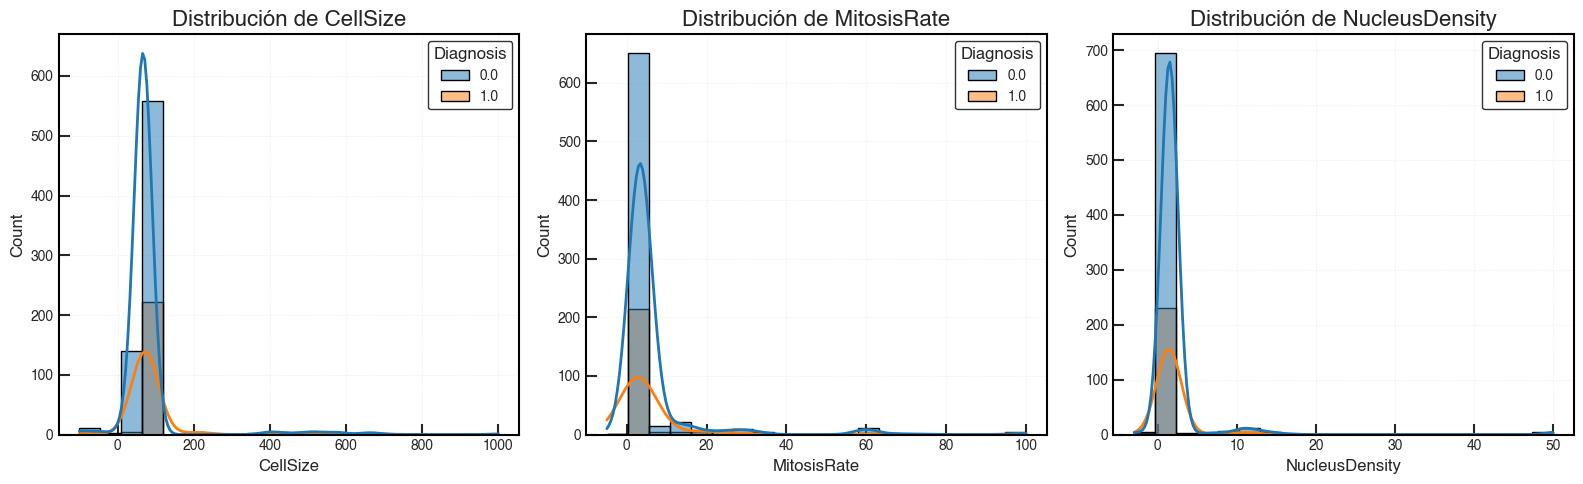

In [47]:
fig = plot_numerical_distributions(
    cell_diagnosis_imbalanced_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    features_to_plot=FEATURES_TO_PLOT,
    figsize=(16, 5),
    output_dir="figures",
    filename="numerical_distributions_outliers.png"
)
plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced_outliers.png


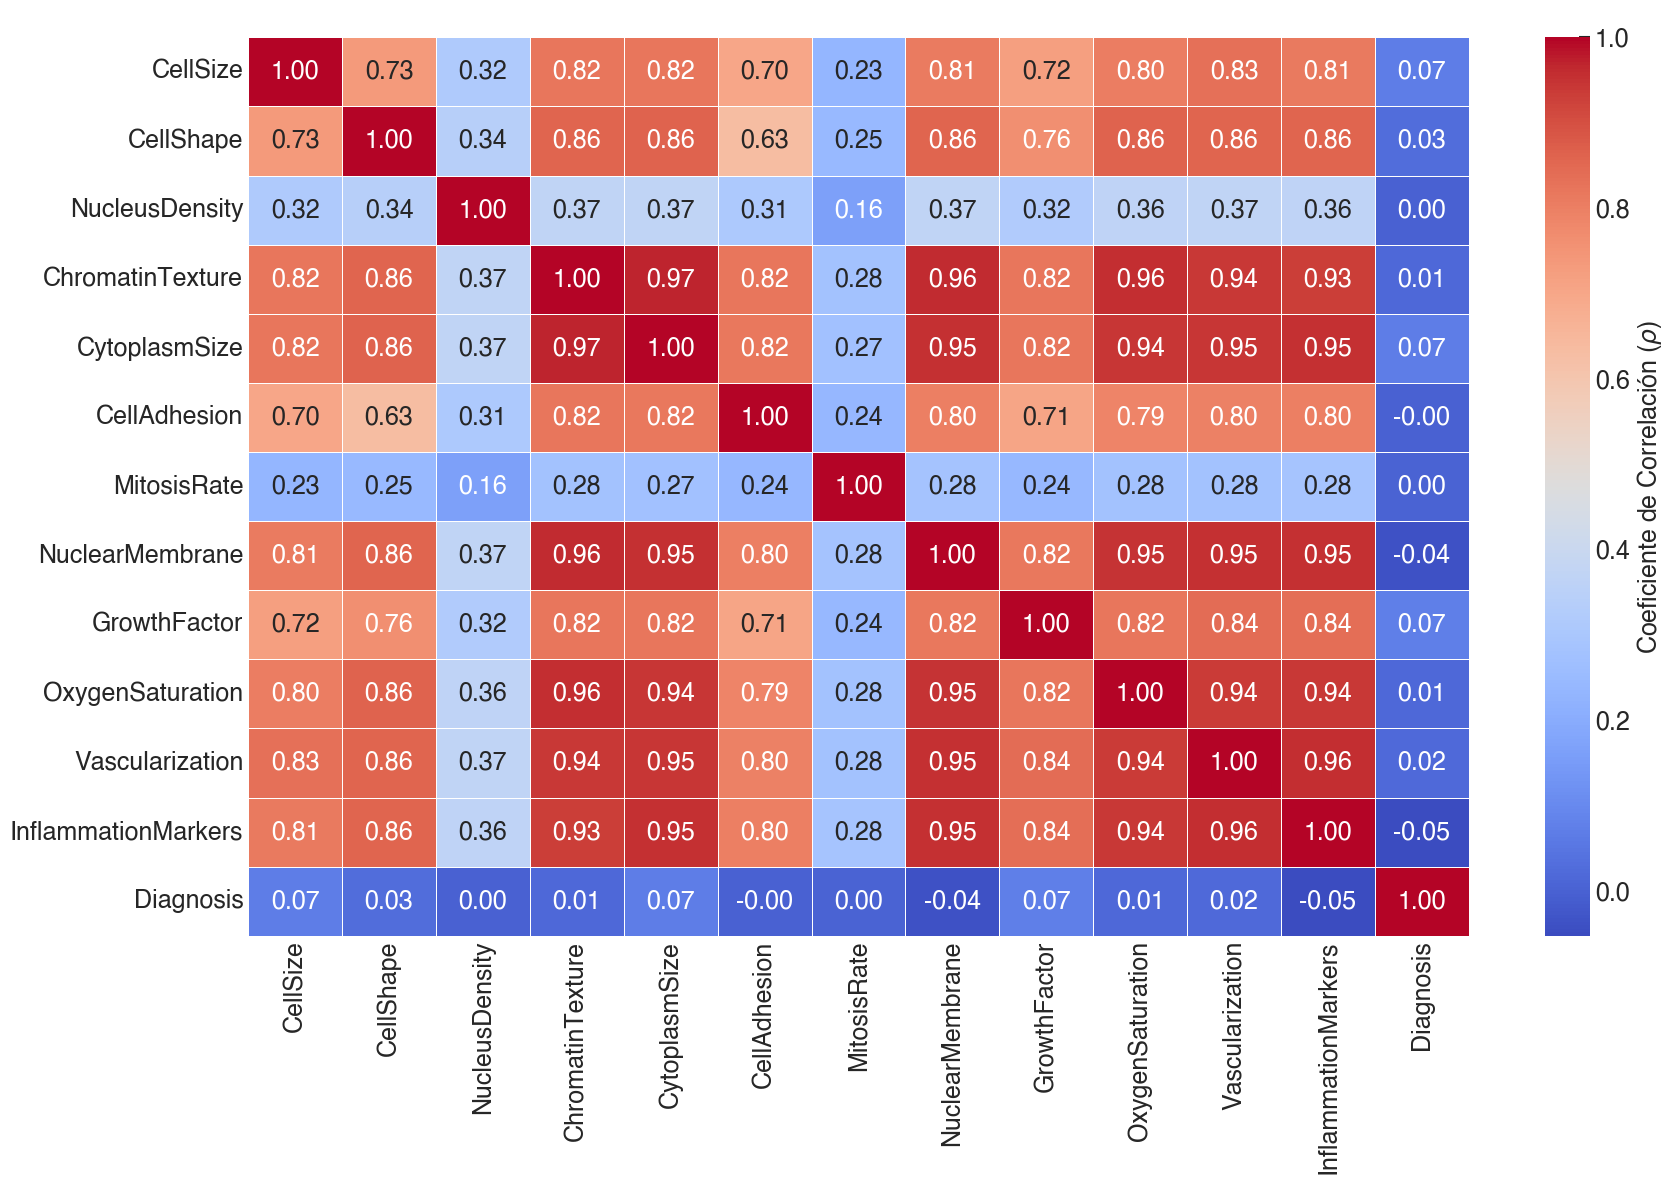

In [48]:
fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced_outliers.png",
    title=" ",
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18, 12)
)
plt.show()

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced_outliers.png


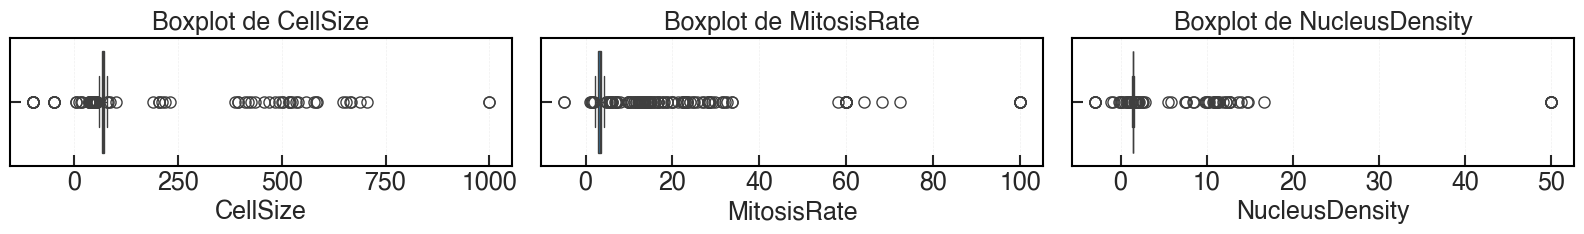

In [49]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_train_outliers,
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename="boxplots_analysis_imbalanced_outliers.png",
    show_plots=True
)

In [50]:
print(f"Clases en dev: {cell_diagnosis_imbalanced_dev_outliers['Diagnosis'].unique()}")
cell_diagnosis_imbalanced_train, params = replace_outliers_iqr(
    cell_diagnosis_imbalanced_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_valid = replace_outliers_iqr(
    cell_diagnosis_imbalanced_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_test = replace_outliers_iqr(
    cell_diagnosis_imbalanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_dev = pd.concat(
    [cell_diagnosis_imbalanced_train, cell_diagnosis_imbalanced_valid],
    ignore_index=False,
    sort=False
)
print(f"Clases en train: {cell_diagnosis_imbalanced_dev_outliers['Diagnosis'].unique()}")


Clases en dev: [0. 1.]
Clases en train: [0. 1.]


In [51]:
data_dict = {
    'df_train': cell_diagnosis_imbalanced_train,
    'df_valid': cell_diagnosis_imbalanced_valid,
    'df_test': cell_diagnosis_imbalanced_test,
    'df_dev': cell_diagnosis_imbalanced_dev
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="processed"
)

In [52]:

loader_cell_diagnosis_imbalanced.load_data(
    train_file="processed/cell_diagnosis_imbalanced_train.csv",
    valid_file="processed/cell_diagnosis_imbalanced_valid.csv",
    test_file="processed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced.png


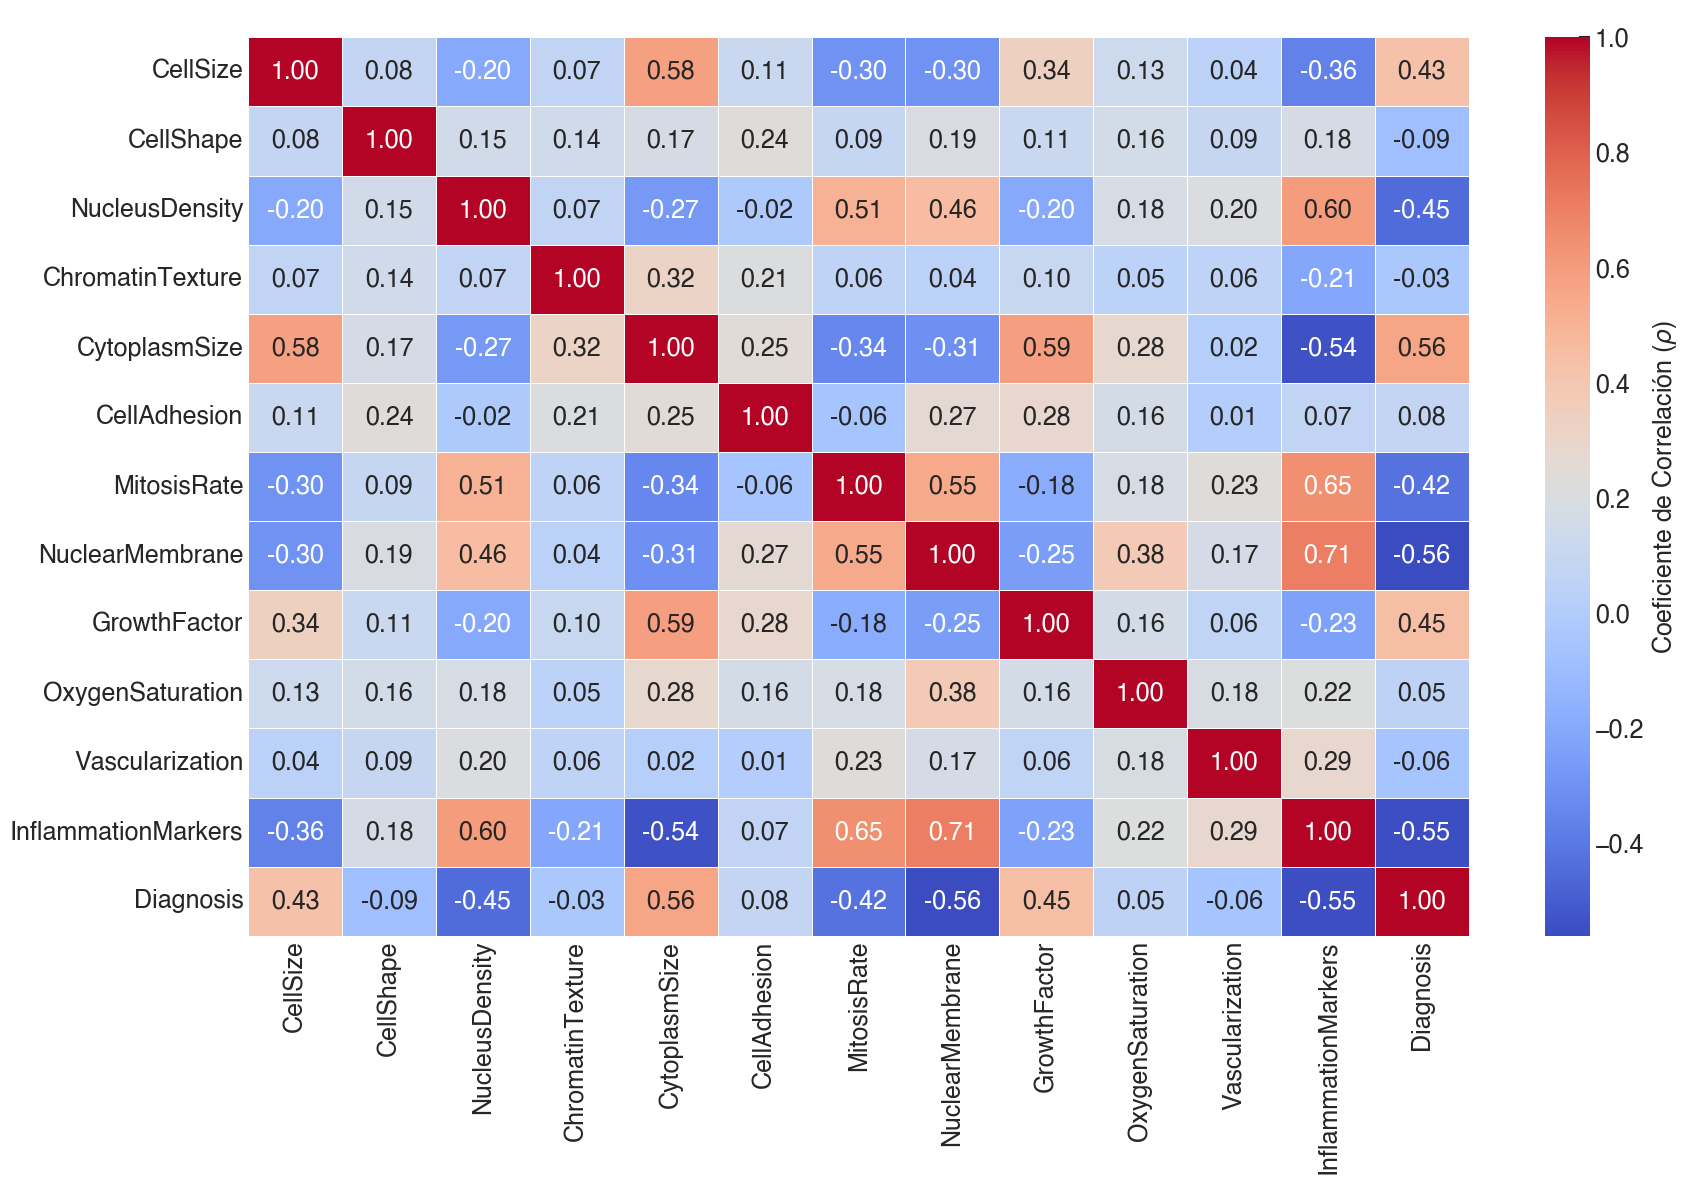

In [53]:
fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_valid,
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced.png",
    title=" ",
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18, 12)
)
plt.show()

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced.png


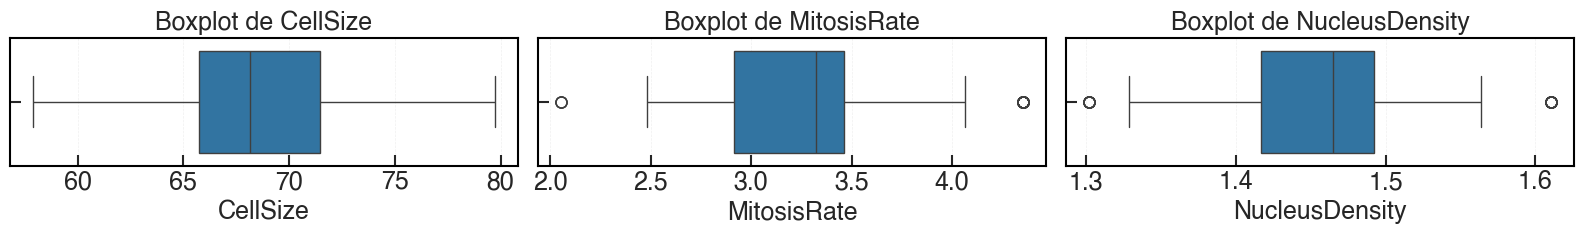

In [54]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_valid,
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename="boxplots_analysis_imbalanced.png",
    show_plots=True
)

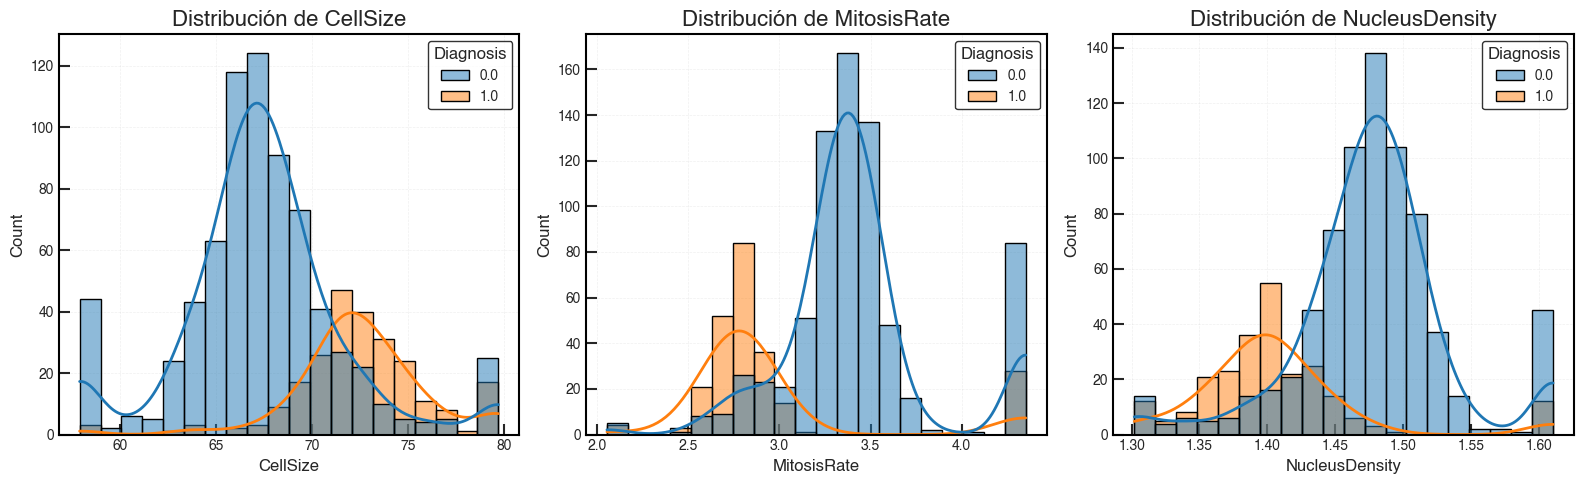

In [55]:
results = plot_numerical_distributions(
    cell_diagnosis_imbalanced_train,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    features_to_plot=FEATURES_TO_PLOT,
    figsize=(16, 5),
)

In [56]:
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from models.logistic_regression_with_cost import CostSensitiveLogisticRegression, CostSensitiveLogisticRegressionConfig
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.rebalancing import (
    RandomUnderSampler, 
    RandomOverSampler, 
    SMOTE, 
    SMOTEConfig,
    RebalancingConfig
)
from utils.utils import evaluate_model
from utils.visuals import plot_roc_curve, plot_precision_recall_curve

In [57]:

def calculate_class_weights(y):
    """
    Calculate class weights for cost-sensitive learning according to the formula C = π2/π1
    where π1 is the prior probability of the minority class and π2 is the prior probability 
    of the majority class.
    
    Parameters
    ----------
    y : np.ndarray
        Target vector with class labels
        
    Returns
    -------
    Dict[int, float]
        Dictionary mapping class labels to weights
    """
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)

    # Calculate class probabilities
    probs = counts / total

    # Find majority class and its probability
    majority_idx = np.argmax(counts)
    majority_class = classes[majority_idx]
    majority_prob = probs[majority_idx]

    # Initialize weights with 1.0 for all classes
    weights = {cls: 1.0 for cls in classes}

    # Apply weight C = π2/π1 only to minority classes
    for i, cls in enumerate(classes):
        if cls != majority_class:  # If it's a minority class
            weights[cls] = majority_prob / probs[i]
            
    # Log the weights for debugging
    print(f"Class weights: {weights}")
    print(f"Class probabilities: {dict(zip(classes, probs))}")
    
    return weights

Parametros de la regresion logistica

In [58]:
lambda_reg = 1
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=lambda_reg,
    random_state=42,
    verbose=True
)

In [59]:
cell_diagnosis_imbalanced_dev = cell_diagnosis_imbalanced_dev.reset_index(drop=True)
cell_diagnosis_imbalanced_valid = cell_diagnosis_imbalanced_valid.reset_index(drop=True)
cell_diagnosis_imbalanced_train = cell_diagnosis_imbalanced_train.reset_index(drop=True)


X_train_cell_diagnosis_imbalanced = cell_diagnosis_imbalanced_train.drop(columns=["Diagnosis"])
y_train_cell_diagnosis_imbalanced = cell_diagnosis_imbalanced_train["Diagnosis"].to_numpy()

X_val_cell_diagnosis_imbalanced =  cell_diagnosis_imbalanced_valid.drop(columns=["Diagnosis"])
y_val_cell_diagnosis_imbalanced = cell_diagnosis_imbalanced_valid["Diagnosis"].to_numpy()


# Encode categorical variables
X_train_cell_diagnosis_imbalanced = DataLoader.encode_categorical(X_train_cell_diagnosis_imbalanced).to_numpy()
X_val_cell_diagnosis_imbalanced = DataLoader.encode_categorical(X_val_cell_diagnosis_imbalanced).to_numpy()



In [60]:
X_test_cell_diagnosis_imbalanced, y_test_cell_diagnosis_imbalanced = loader_cell_diagnosis_imbalanced.get_processed_test_data(
    return_numpy=True,
    encode_categorical=True,
    normalize=False
)


In [61]:
class_names = ["Malignant","Benign" ]

In [62]:
all_models = {}

In [63]:
# --- Validación cruzada sin rebalancing para elegir lambda ---
# Se asume que ya se tiene definido un rango de valores para lambda_values y la función f1_score.
best_lambda_nr, cv_scores_nr = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced,
    y=y_train_cell_diagnosis_imbalanced,
    lambda_values=lambda_values,       # Por ejemplo, un np.concatenate de logspace
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    aggregate_predictions=True,         # Calcula la métrica global al final
    resampler=None                      # No aplica re-muestreo en este caso
)

print(f"Optimal lambda for non-rebalancing: {best_lambda_nr}")

# --- Configurar la regresión logística con el lambda óptimo obtenido ---

lr_config_no_rebalancing = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_nr,
    random_state=42,
    verbose=False
)


# --- Entrenamiento del modelo sin aplicar ninguna técnica de rebalancing ---
model_no_rebalancing = LogisticRegression(lr_config_no_rebalancing)
model_no_rebalancing.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# --- Evaluación del modelo en el conjunto de validación ---
metrics_no_rebalancing = evaluate_model(
    model=model_no_rebalancing,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=False
)

all_models["No rebalancing"] = {
    "model": model_no_rebalancing,
    "metrics": metrics_no_rebalancing
}


Optimal lambda for non-rebalancing: 6.294988990221888


In [64]:
# Primero, definimos la estrategia de undersampling:
undersampler = RandomUnderSampler(RebalancingConfig(random_state=42, sampling_strategy=0.5))


# Realizar validación cruzada aplicando undersampling en cada fold
best_lambda_under, cv_scores_under = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced,
    y=y_train_cell_diagnosis_imbalanced,
    lambda_values=lambda_values,
    metric_fn=f1_score,           # O la métrica que prefieras
    k_folds=5,
    verbose=False,
    threshold=0.6,
    aggregate_predictions=True,   # Calcula la métrica global al final
    resampler=undersampler         # Aplica undersampling en cada fold
)

print(f"\nOptimal lambda for undersampling: {best_lambda_under}")

# Crear la configuración final del modelo con el lambda óptimo obtenido
lr_config_under = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_under,
    random_state=42,
    verbose=False
)

# Re-aplicar undersampling al conjunto de entrenamiento final (para consistencia)
X_train_under, y_train_under = undersampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# Entrenar el modelo final con la configuración optimizada
model_undersampling = LogisticRegression(lr_config_under)
model_undersampling.fit(X_train_under, y_train_under)

# Evaluar el modelo en el conjunto de validación
metrics_undersampling = evaluate_model(
    threshold=0.6,
    model=model_undersampling, 
    X_test=X_val_cell_diagnosis_imbalanced, 
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    figsize=(10, 6), 
    print_metrics=False
)

# Agregar el modelo y sus métricas al diccionario de modelos evaluados
all_models["Undersampling"] = {
    "model": model_undersampling,
    "metrics": metrics_undersampling
}



Optimal lambda for undersampling: 0.0020022003718155844


In [65]:
# --- Definir el oversampler y re-muestrear el conjunto de entrenamiento original ---
oversampler = RandomOverSampler(RebalancingConfig(random_state=42))



# --- Definir un rango de valores para lambda ---
lambda_values = np.concatenate([
    np.logspace(-6, -3, 50),
    np.logspace(-3, 1, 200)
])

# --- Realizar validación cruzada utilizando el oversampler ---
# Se utiliza el parámetro "resampler" para que en cada fold se aplique la técnica de re-muestreo.
optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced,             # Se utiliza el conjunto original; el oversampler se aplica internamente
    y=y_train_cell_diagnosis_imbalanced,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    resampler=oversampler  # Aplica oversampling en cada fold
)

print(f"\nOptimal lambda: {optimal_lambda}")

# --- Configurar el modelo con el lambda óptimo ---
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


# --- Re-aplicar oversampling al conjunto de entrenamiento para el entrenamiento final ---
X_train_over, y_train_over = oversampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# --- Entrenar el modelo final con la configuración optimizada ---
model_oversampling = LogisticRegression(lr_config)
model_oversampling.fit(X_train_over, y_train_over)

# --- Evaluar el modelo final en el conjunto de validación ---
metrics_oversampling = evaluate_model(
    model=model_oversampling,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=False
)

all_models["Oversampling duplicate"] = {
    "model": model_oversampling,
    "metrics": metrics_oversampling
}



Optimal lambda: 5.2310993080562636


In [66]:

smote = SMOTE(SMOTEConfig(random_state=42, k_neighbors=5))

optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced,             # Se utiliza el conjunto original; el oversampler se aplica internamente
    y=y_train_cell_diagnosis_imbalanced,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    resampler=smote  # Aplica oversampling en cada fold
)

print(f"\nOptimal lambda: {optimal_lambda}")

# --- Configurar el modelo con el lambda óptimo ---
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


X_train_smote, y_train_smote = smote.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)
model_smote = LogisticRegression(lr_config)
model_smote.fit(X_train_smote, y_train_smote);

metrics_smote = evaluate_model(
    model_smote, X_val_cell_diagnosis_imbalanced, y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)
all_models["Oversampling SMOTE"] = {
    "model": model_smote,
    "metrics": metrics_smote
}


Optimal lambda: 3.5564803062231285e-06


In [67]:
print("\n===== Training model with Cost reweighting =====")
# Calcula los pesos de clase (por ejemplo, usando una función calculate_class_weights que ya tengas)
class_weights = calculate_class_weights(y_train_cell_diagnosis_imbalanced)
print(f"Class weights: {class_weights}")


# Realizar validación cruzada cost-sensitive para elegir el mejor lambda:
# Se pasa el parámetro resampler si se desea aplicar alguna técnica de re-muestreo en cada fold; de lo contrario, se puede dejar como None.
best_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced,
    y=y_train_cell_diagnosis_imbalanced,
    lambda_values=lambda_values,
    metric_fn=f1_score,           # Puedes elegir la métrica que prefieras
    k_folds=5,
    verbose=False,
    threshold=0.5,
    aggregate_predictions=True,   # Calcula la métrica al final usando todas las predicciones
    resampler=None                # O reemplázalo por un resampler (por ejemplo, oversampler) si lo deseas
)

print(f"\nOptimal lambda found: {best_lambda}")

# Crear la configuración del modelo cost-sensitive con el lambda óptimo obtenido
cost_sensitive_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=best_lambda,
    random_state=42,
    verbose=False,
    class_weight=class_weights
)
model_cost = LogisticRegression(cost_sensitive_config)
model_cost.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# Evaluar el modelo entrenado en el conjunto de validación
metrics_cost = evaluate_model(
    model=model_cost,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=False
)

all_models["Cost re-weighting"] = {
    "model": model_cost,
    "metrics": metrics_cost
}



===== Training model with Cost reweighting =====
Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0123456790123457)}
Class probabilities: {np.float64(0.0): np.float64(0.7507692307692307), np.float64(1.0): np.float64(0.24923076923076923)}
Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0123456790123457)}

Optimal lambda found: 6.294988990221888


Evaluando modelos en el conjunto de validation
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting


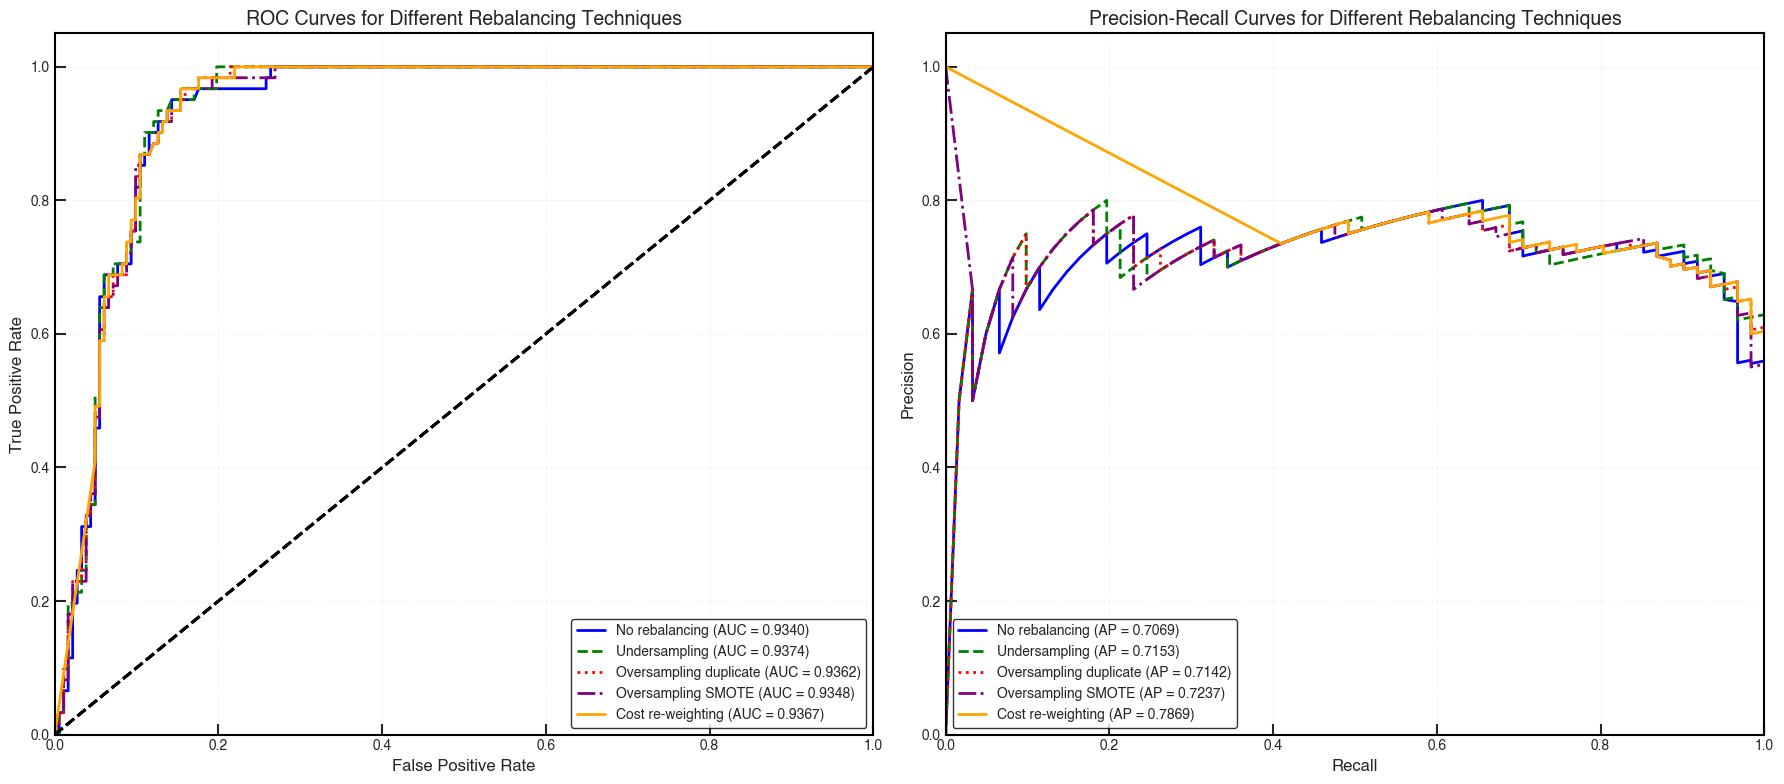

In [68]:
# Antes de ejecutar evaluate_all_models, necesitamos asegurar que y_val_cell_diagnosis_imbalanced sea un array NumPy
y_val_cell_diagnosis_imbalanced = np.asarray(y_val_cell_diagnosis_imbalanced)

val_metrics_df, val_metrics = evaluate_all_models(
    all_models, 
    X_val_cell_diagnosis_imbalanced, 
    y_val_cell_diagnosis_imbalanced, 
    class_names, 
    fig_output_dir_p1,
    prefix="validation",
    subplots=True,
    show_plot=True,
    individual_plots=False
)

Evaluando modelos en el conjunto de test
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting


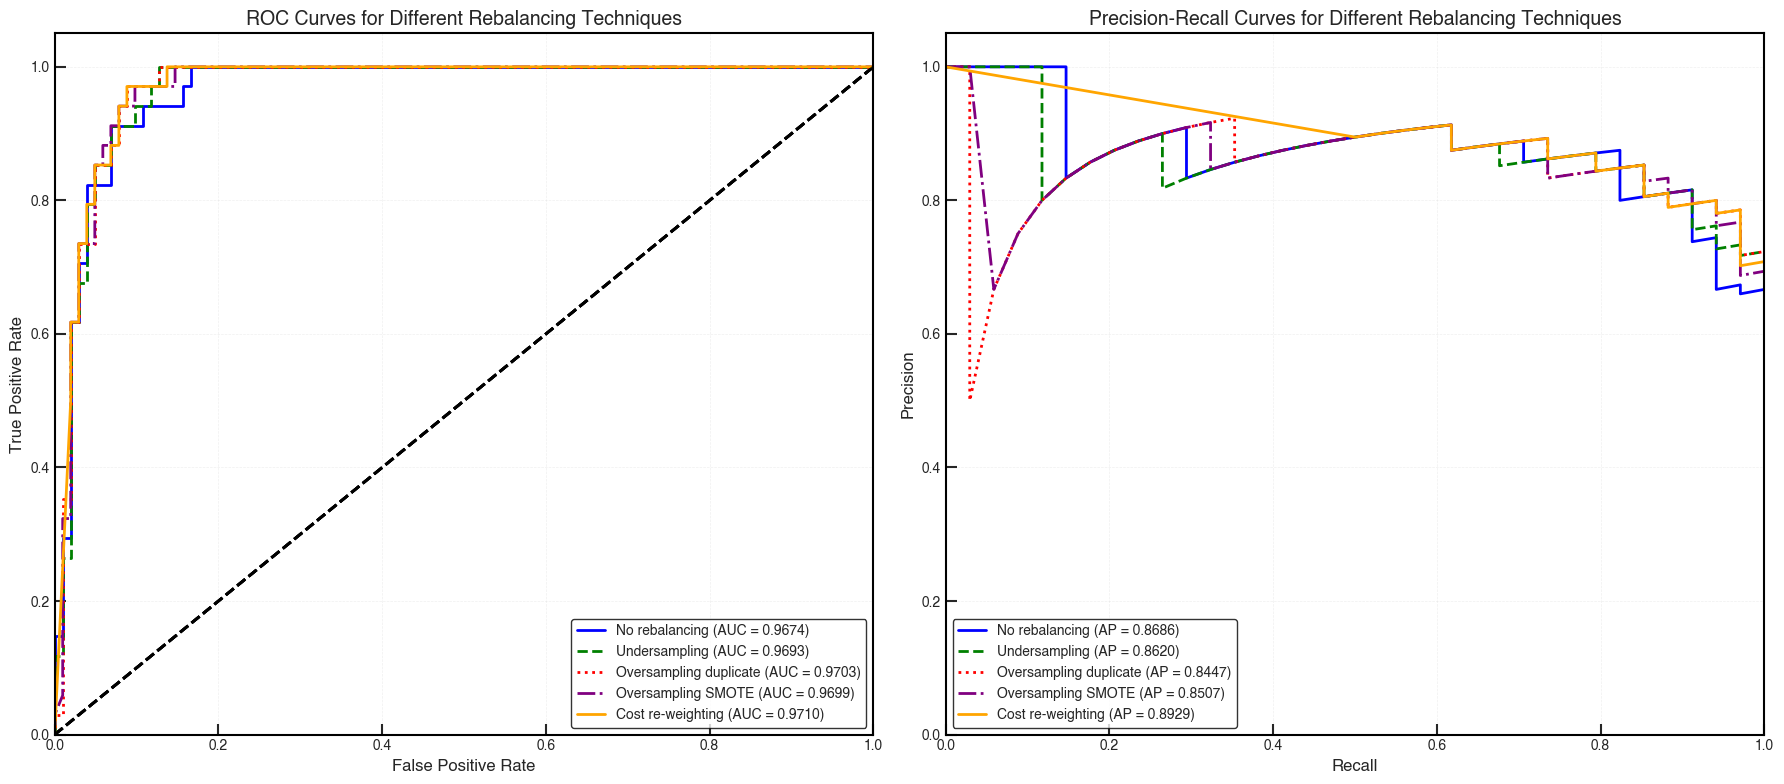

In [69]:
test_metrics_df, test_metrics = evaluate_all_models(
    all_models, 
    X_test_cell_diagnosis_imbalanced, 
    y_test_cell_diagnosis_imbalanced, 
    class_names, 
    fig_output_dir_p1,
    subplots=True,
    prefix="test",
    show_plot=True,
    individual_plots=False
)

In [70]:

def format_metrics_table(metrics_df, title="Metrics Summary"):
    """
    Formatea una tabla de métricas para mostrar, extrayendo valores AUC de diccionarios cuando sea necesario.
    
    Args:
        metrics_df (pd.DataFrame): DataFrame con las métricas a formatear
        title (str): Título a mostrar antes de la tabla
        
    Returns:
        pd.DataFrame: DataFrame formateado para visualización
    """
    # Crear una copia para no modificar el original
    display_df = metrics_df.copy()
    
    # Formatear columnas AUC si contienen diccionarios
    for col in ['AUC-ROC', 'AUC-PR']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(
                lambda x: f"{x['auc']:.4f}" if isinstance(x, dict) and 'auc' in x 
                else (f"{x['average_precision']:.4f}" if isinstance(x, dict) and 'average_precision' in x 
                else str(x))
            )
    
    print(f"\n===== {title} =====")
    display(display_df)
    return display_df

val_metrics_display = format_metrics_table(val_metrics_df, "Validation Metrics Summary")
test_metrics_display = format_metrics_table(test_metrics_df, "Test Metrics Summary")


===== Validation Metrics Summary =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.8601    0.7288  0.7049  0.7167  0.9340  0.7069
1           Undersampling   0.7613    0.7143  0.0820  0.1471  0.9374  0.7153
2  Oversampling duplicate   0.8848    0.7324  0.8525  0.7879  0.9362  0.7142
3      Oversampling SMOTE   0.8889    0.7361  0.8689  0.7970  0.9348  0.7237
4       Cost re-weighting   0.8889    0.7361  0.8689  0.7970  0.9367  0.7869


===== Test Metrics Summary =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.8971    0.8846  0.6765  0.7667  0.9674  0.8686
1           Undersampling   0.7868    0.8571  0.1765  0.2927  0.9693  0.8620
2  Oversampling duplicate   0.9191    0.8286  0.8529  0.8406  0.9703  0.8447
3      Oversampling SMOTE   0.9191    0.8286  0.8529  0.8406  0.9699  0.8507
4       Cost re-weighting   0.9191    0.8286  0.8529  0.8406  0.9710  0.8929

%% Punto 1.6: Selección de Modelo Final<br>
Se utilizaría el modelo de SMOTE PORQUE TATARARARTATAR ............................... ENTRENAR CON DEV ENTERO

# Punto 2: Análisis del Dataset WAR_class

In [71]:
fig_output_dir_p2 = "./figures/p2"
os.makedirs(fig_output_dir_p2, exist_ok=True)
data_dir_p2 = data_dir / "p2"

In [72]:
config_war_class = DatasetConfig(
    data_dir=data_dir_p2,
    target_column="war_class",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_war_class = DataLoader(config_war_class)
loader_war_class.load_data(
    dev_file="raw/WAR_class_dev.csv",
    test_file="raw/WAR_class_test.csv",
    splitted=False
)
war_class_dev, war_class_test = loader_war_class.get_pandas_data(splitted=False)

In [73]:
war_class_train, war_class_valid = train_valid_split(war_class_dev, test_size=0.2, random_state=42)
print("Valores nulos en conjunto de entrenamiento:")
print(war_class_train.isnull().sum().sum())
print("Valores nulos en conjunto de validación:")
print(war_class_valid.isnull().sum().sum())

Valores nulos en conjunto de entrenamiento:
0
Valores nulos en conjunto de validación:
0


In [74]:
print("WAR_class_train.csv - Información básica:")
print(f"Número de filas: {war_class_train.shape[0]}")
print(f"Número de columnas: {war_class_train.shape[1]}")
print("\nPrimeras filas del dataset:")
display(war_class_train.head())


WAR_class_train.csv - Información básica:
Número de filas: 5426
Número de columnas: 6

Primeras filas del dataset:


poss           mp  raptor_total  war_total  pace_impact  \
4698  1868.699101  1014.148270     -5.007210  -1.502452    -0.095117   
2615  1707.472466   796.174060     -5.836661  -1.035020     0.094600   
149   5567.712437  3045.743338      6.877886  13.557850     0.463237   
2771  2308.445281  1078.276038     -0.146617   1.440371     0.401561   
3628  2567.084771  1105.957572      1.402560   2.551115     0.410492   

      war_class  
4698          1  
2615          2  
149           3  
2771          2  
3628          2

In [75]:
analyze_null_values(
    [war_class_train, war_class_test],
    ["conjunto de entrenamiento WAR_class", "conjunto de prueba WAR_class"]
);

Valores nulos en conjunto de entrenamiento WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      5426           100.0
2                    Total de muestras      5426           100.0



Valores nulos en conjunto de prueba WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      1696           100.0
2                    Total de muestras      1696           100.0

In [76]:
duplicated_rows = war_class_train.duplicated().sum()
print(f"Número de filas duplicadas en WAR_class_dev: {duplicated_rows}")

Número de filas duplicadas en WAR_class_dev: 0


In [77]:
analyze_categorical_variables(war_class_train, ["war_class"])

Categorical variables distribution:

war_class distribution:


war_class  Count  Percentage (%)
0          2   2000           36.86
1          3   1806           33.28
2          1   1620           29.86

In [78]:
numerical_cols_war = war_class_train.select_dtypes(include=["number"]).columns.tolist()
numerical_cols_war = [col for col in numerical_cols_war if col != "war_class"]

In [79]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_train[col].min():.2f} a {war_class_train[col].max():.2f} (promedio: {war_class_train[col].mean():.2f})")


Características principales:
  poss: -414.39 a 9329.40 (promedio: 3622.14)
  mp: -235.33 a 4264.46 (promedio: 1803.11)
  raptor_total: -43.45 a 32.90 (promedio: -1.48)
  war_total: -6.59 a 28.76 (promedio: 2.78)
  pace_impact: -6.94 a 11.19 (promedio: 0.09)


quitamos valores negativos (los ponemos como NAN y usamos KNN para imputarlos)

In [80]:
def remove_negative_values(df, columns):
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Count and replace negative values
    number_of_negative_values = 0
    for col in columns:
        # Only check non-NaN values
        mask = (df_copy[col] < 0) & df_copy[col].notna()
        number_of_negative_values += mask.sum()
        df_copy.loc[mask, col] = np.nan
    
    return df_copy, number_of_negative_values

numerical_cols_to_remove_negatives = ["poss", "mp", "war_total"]
# Apply the function to each dataframe
war_class_train, neg_count_train = remove_negative_values(war_class_train, numerical_cols_to_remove_negatives)
war_class_valid, neg_count_valid = remove_negative_values(war_class_valid, numerical_cols_to_remove_negatives)
war_class_test, neg_count_test = remove_negative_values(war_class_test, numerical_cols_to_remove_negatives)

# Print results
print(f"Replaced {neg_count_train} negative values in training set")
print(f"Replaced {neg_count_valid} negative values in validation set")
print(f"Replaced {neg_count_test} negative values in test set")

# Now impute missing values
imputed_train, imputed_valid, imputed_test = impute_missing_values(
    war_class_train,
    war_class_valid,
    war_class_test,
    knn_neighbors=5,
    knn_weights="distance"
)

# Continue with your workflow using the imputed dataframes
war_class_train = imputed_train
war_class_valid = imputed_valid
war_class_test = imputed_test

Replaced 2533 negative values in training set
Replaced 632 negative values in validation set
Replaced 773 negative values in test set
Missing values before imputation:
Train: 2533 missing values
Valid: 632 missing values
Test: 773 missing values

Missing values after imputation:
Train: 2181 missing values
Valid: 527 missing values
Test: 651 missing values


In [81]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_train[col].min():.2f} a {war_class_train[col].max():.2f} (promedio: {war_class_train[col].mean():.2f})")


Características principales:
  poss: 4.24 a 9329.40 (promedio: 3631.79)
  mp: 0.23 a 4264.46 (promedio: 1808.94)
  raptor_total: -43.45 a 32.90 (promedio: -1.48)
  war_total: 0.00 a 28.76 (promedio: 5.80)
  pace_impact: -6.94 a 11.19 (promedio: 0.09)


Gráfico guardado en: ./figures/p2/boxplots_analysis_war_class.png


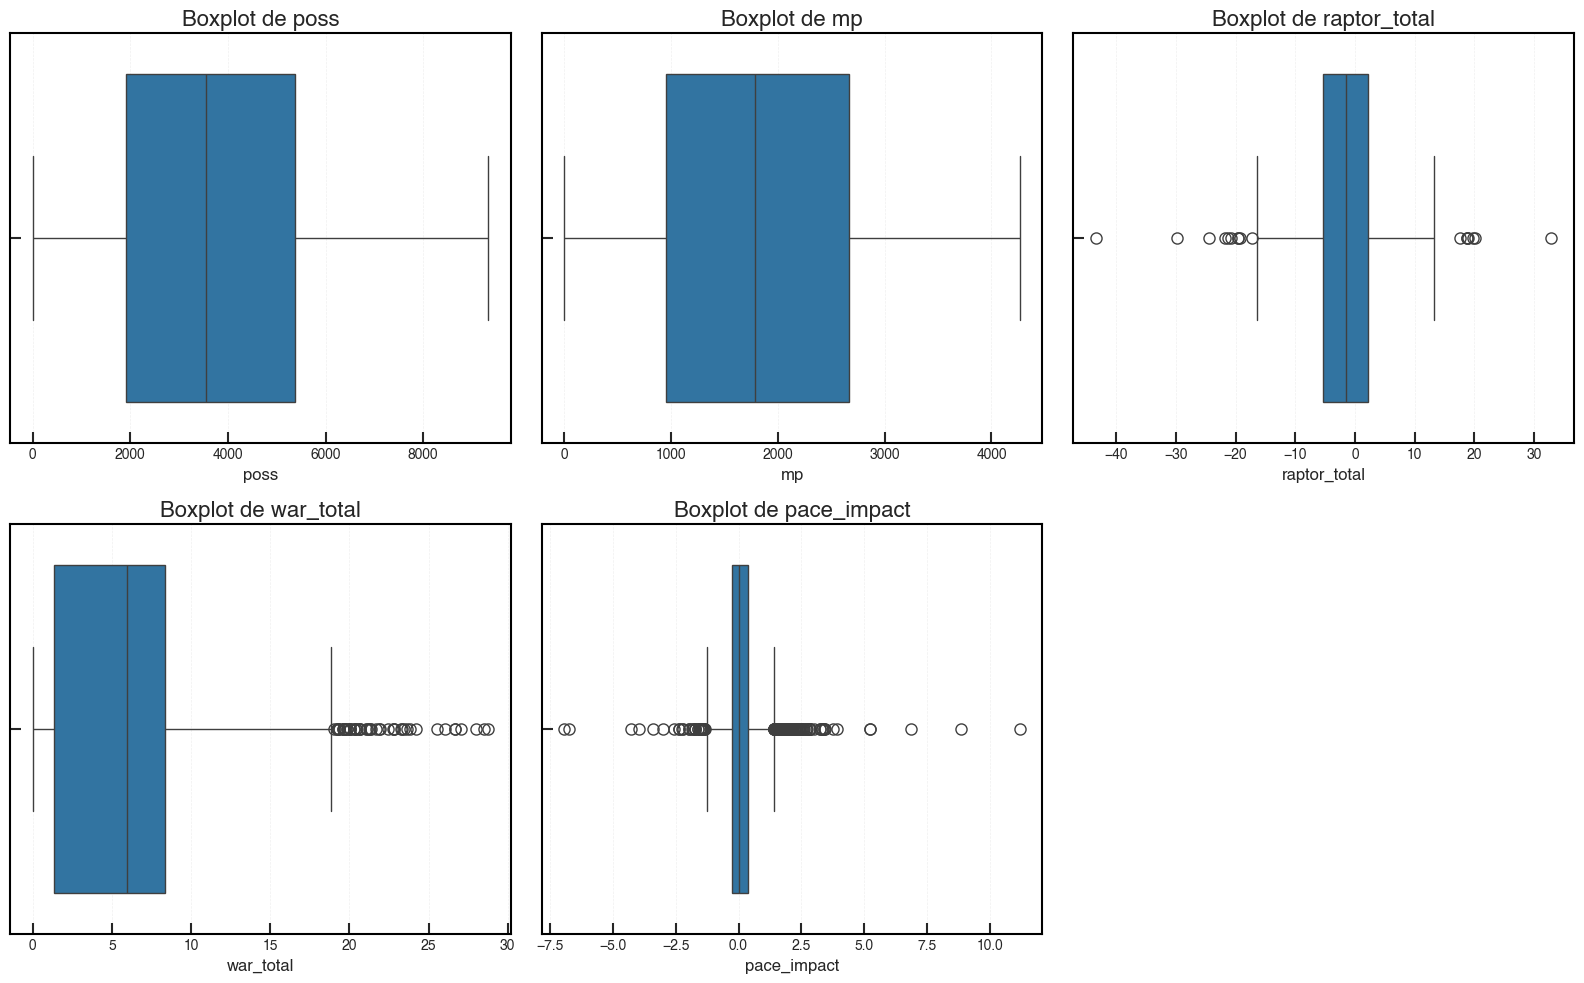

In [82]:
fig = plot_outliers_analysis(
    df=war_class_train,
    features_to_plot=numerical_cols_war,
    columns=numerical_cols_war,
    save_dir=fig_output_dir_p2,
    filename="boxplots_analysis_war_class.png",
    figsize=(16, 10),
    show_plots=True
);

In [83]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_train[col].min():.2f} a {war_class_train[col].max():.2f} (promedio: {war_class_train[col].mean():.2f})")


Características principales:
  poss: 4.24 a 9329.40 (promedio: 3631.79)
  mp: 0.23 a 4264.46 (promedio: 1808.94)
  raptor_total: -43.45 a 32.90 (promedio: -1.48)
  war_total: 0.00 a 28.76 (promedio: 5.80)
  pace_impact: -6.94 a 11.19 (promedio: 0.09)


In [84]:
war_class_train, war_iqr_params = replace_outliers_iqr(war_class_train, method="winsorize", target_column="war_class",return_params=True)
war_class_valid = replace_outliers_iqr(war_class_valid, method="winsorize", params=war_iqr_params, target_column="war_class")
war_class_test = replace_outliers_iqr(war_class_test, method="winsorize", params=war_iqr_params, target_column="war_class")

war_class_dev = pd.concat([war_class_train, war_class_valid],ignore_index=False,sort=False)

war_class_dev_preprocessed = pd.concat([war_class_train, war_class_valid])

loader_war_class.update(
    df_train=war_class_train,
    df_valid=war_class_valid,
    df_test=war_class_test
);

df_preprocessed_war_class_train_dir = data_dir / "p2" / "preprocessed" / "WAR_class_train.csv"
df_preprocessed_war_class_valid_dir = data_dir / "p2" / "preprocessed" / "WAR_class_valid.csv"
df_preprocessed_war_class_test_dir = data_dir / "p2" / "preprocessed" / "WAR_class_test.csv"
df_preprocessed_war_class_dev_dir = data_dir / "p2" / "preprocessed" / "WAR_class_dev.csv"

os.makedirs(data_dir / "p2" / "preprocessed", exist_ok=True)
pd.DataFrame(war_class_dev_preprocessed).to_csv(df_preprocessed_war_class_dev_dir, index=False)

loader_war_class.save_processed_data(
    df_train_dir=df_preprocessed_war_class_train_dir,
    df_valid_dir=df_preprocessed_war_class_valid_dir,
    df_test_dir=df_preprocessed_war_class_test_dir,
    df_dev_dir=df_preprocessed_war_class_dev_dir
);


In [85]:
print("\nCaracterísticas principales luego de reemplazar outliers:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_train[col].min():.2f} a {war_class_train[col].max():.2f} (promedio: {war_class_train[col].mean():.2f})")


Características principales luego de reemplazar outliers:
  poss: 4.24 a 9329.40 (promedio: 3631.79)
  mp: 0.23 a 4264.46 (promedio: 1808.94)
  raptor_total: -16.50 a 13.39 (promedio: -1.48)
  war_total: 0.00 a 18.93 (promedio: 5.76)
  pace_impact: -1.29 a 1.41 (promedio: 0.08)


In [86]:
print(f"Número total de muestras en entrenamiento: {len(war_class_train)}")
print(f"Número total de muestras en validación: {len(war_class_valid)}")
print(f"Número total de muestras en test: {len(war_class_test)}")
print(f"Número de features: {len(numerical_cols_war)}")


Número total de muestras en entrenamiento: 5426
Número total de muestras en validación: 1356
Número total de muestras en test: 1696
Número de features: 5


In [87]:
loader_war_class.load_data(
    train_file="preprocessed/WAR_class_train.csv",
    valid_file="preprocessed/WAR_class_valid.csv",
    test_file="preprocessed/WAR_class_test.csv",
    splitted=True
)
war_class_train, war_class_valid, war_class_test = loader_war_class.get_pandas_data(splitted=True)

Saved figure to ./figures/p2/correlation_heatmap_war_class.png


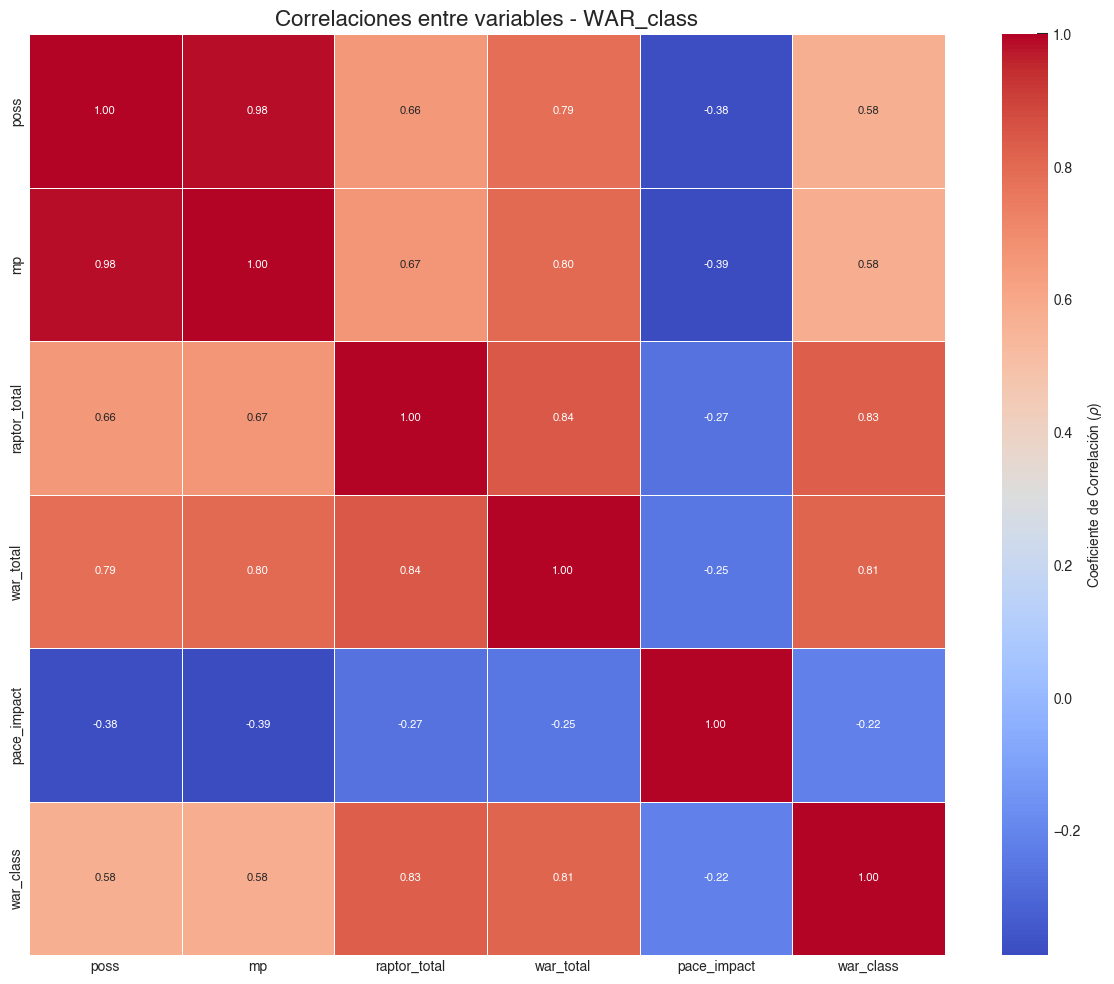

In [88]:
fig = plot_correlation_heatmap(
    war_class_train,
    numerical_cols_war + ["war_class"],
    output_dir=fig_output_dir_p2,
    filename="correlation_heatmap_war_class.png",
    title="Correlaciones entre variables - WAR_class",
    figsize=(12, 10)
)
plt.show()

Saved figure to ./figures/p2/key_features_distributions.png


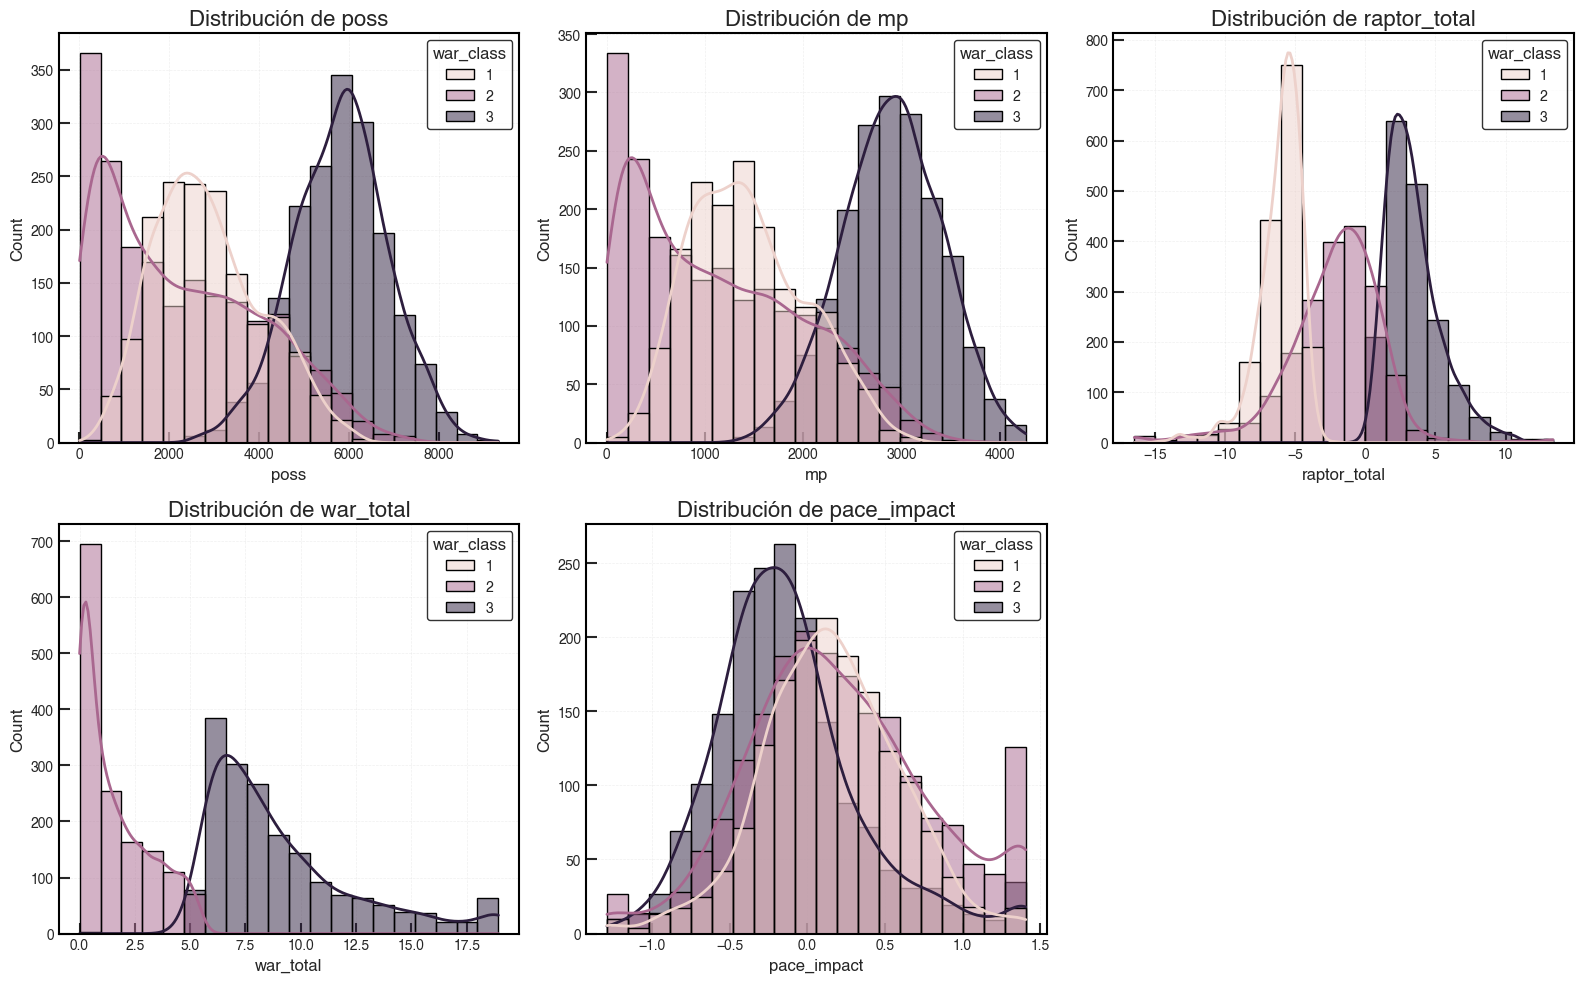

In [89]:
features_to_plot = ["poss", "mp", "raptor_total", "war_total", "pace_impact"]
fig = plot_numerical_distributions(
    war_class_train,
    numerical_cols=features_to_plot,
    target_column="war_class",
    output_dir=fig_output_dir_p2,
    filename="key_features_distributions.png",
    figsize=(16, 10)
)
plt.show()

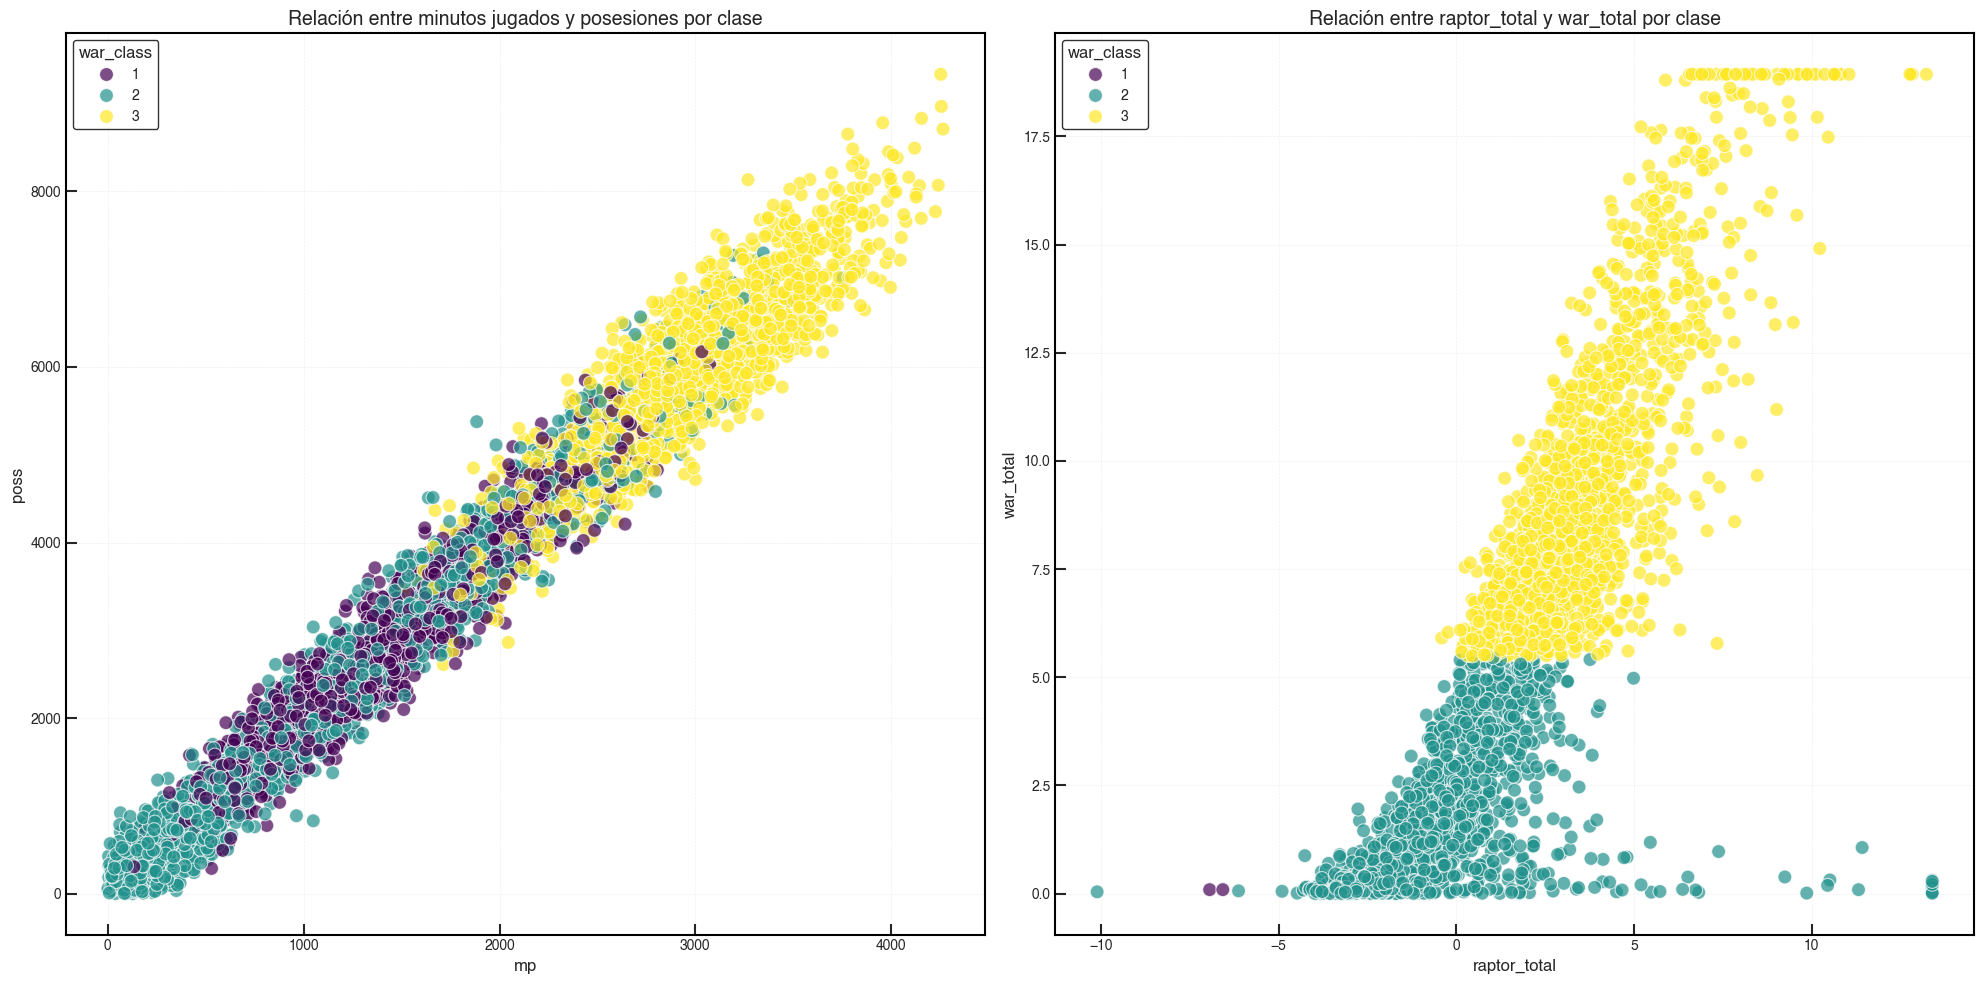

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: relación entre minutos jugados y posesiones
sns.scatterplot(data=war_class_train, x="mp", y="poss", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[0])
axes[0].set_title("Relación entre minutos jugados y posesiones por clase", fontsize=14)
axes[0].grid(True, alpha=0.3)

# Segundo gráfico: relación entre raptor_total y war_total
sns.scatterplot(data=war_class_train, x="raptor_total", y="war_total", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[1])
axes[1].set_title("Relación entre raptor_total y war_total por clase", fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(fig_output_dir_p2, "scatter_relationships.png"), dpi=300, bbox_inches="tight")
plt.show()

## Punto 2.2

In [91]:
def normalize_data(X,params,return_params=False):
    if params is None:
        params = {}
        params["mean"] = X.mean()
        params["std"] = X.std()
    X_normalized = (X - params["mean"]) / params["std"]
    if return_params:
        return X_normalized, params
    return X_normalized



In [92]:
X_train = war_class_train.drop(columns=["war_class","war_total"]).to_numpy()
y_train = war_class_train["war_class"].to_numpy()


X_valid = war_class_valid.drop(columns=["war_class","war_total"]).to_numpy()
y_valid = war_class_valid["war_class"].to_numpy()

X_test = war_class_test.drop(columns=["war_class","war_total"]).to_numpy()
y_test = war_class_test["war_class"].to_numpy()


In [93]:
X_train_normalized, params = normalize_data(X_train, None, return_params=True)
X_valid_normalized = normalize_data(X_valid, params)
X_test_normalized = normalize_data(X_test, params)

In [94]:
from models.random_forest import RandomForest, RandomForestConfig
from models.lda import LDA, LDAConfig

In [95]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train, y_train)




evaluate_model(
    model=lda_model,
    X_test=X_valid,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  # Real class names
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(12, 4)
)






LinAlgError: SVD did not converge

Accuracy: 0.5892
Precision: 0.4098
Recall: 0.5892
F1 Score: 0.4822


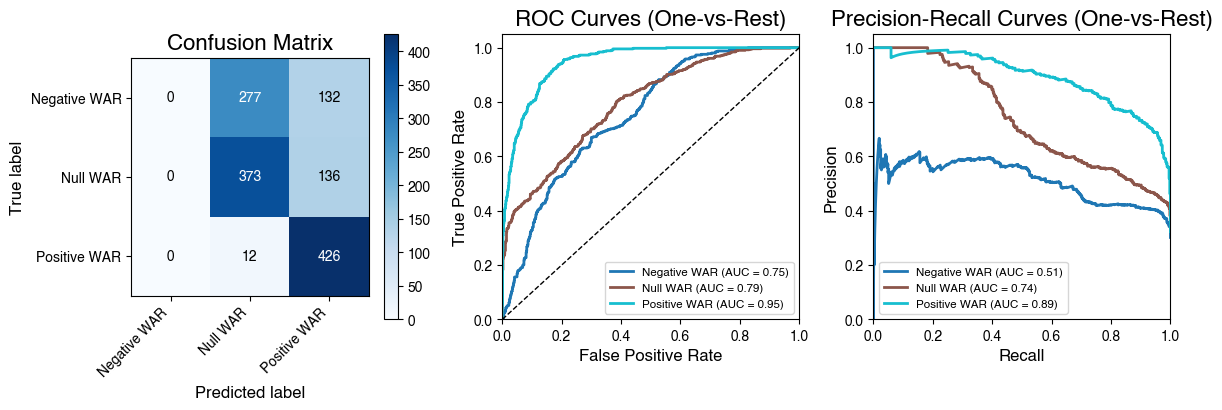

In [158]:
multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=0.1,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)



model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_normalized, y_train)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_valid_normalized,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(12, 4),
    average="weighted"
)

Accuracy: 0.9521
Precision: 0.9522
Recall: 0.9521
F1 Score: 0.9518


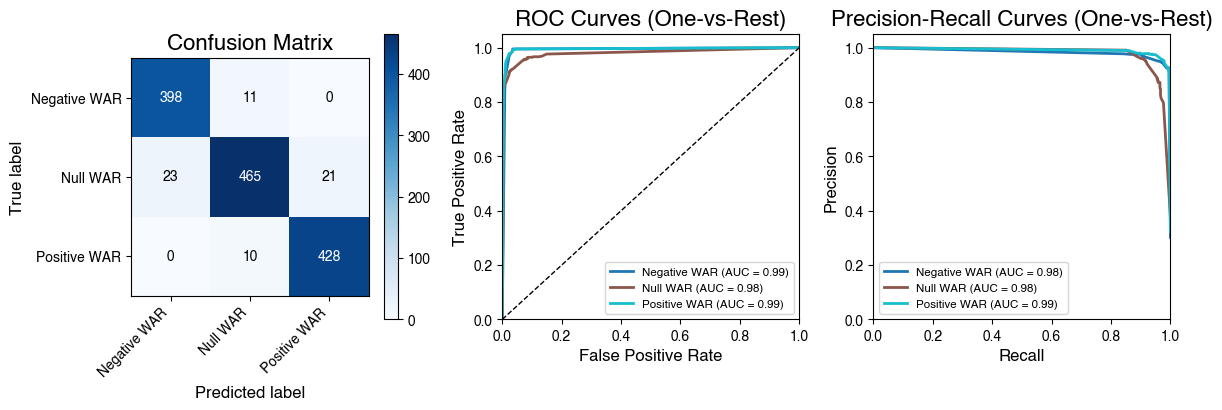

In [159]:
random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train, y_train)


result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_valid,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(12, 4),
    average="weighted"
)





## Punto 2.4

In [160]:
# Combine training and validation sets
X_train_full_dev = np.vstack([X_train, X_valid])
y_train_full_dev = np.concatenate([y_train, y_valid])

# Use test set as is
X_test_full_dev = X_test
y_test_full_dev = y_test

X_train_full_dev_normalized, params = normalize_data(X_train_full_dev, None, return_params=True)
X_test_full_dev_normalized = normalize_data(X_test_full_dev, params)


Accuracy: 0.9004
Precision: 0.9120
Recall: 0.9004
F1 Score: 0.8967


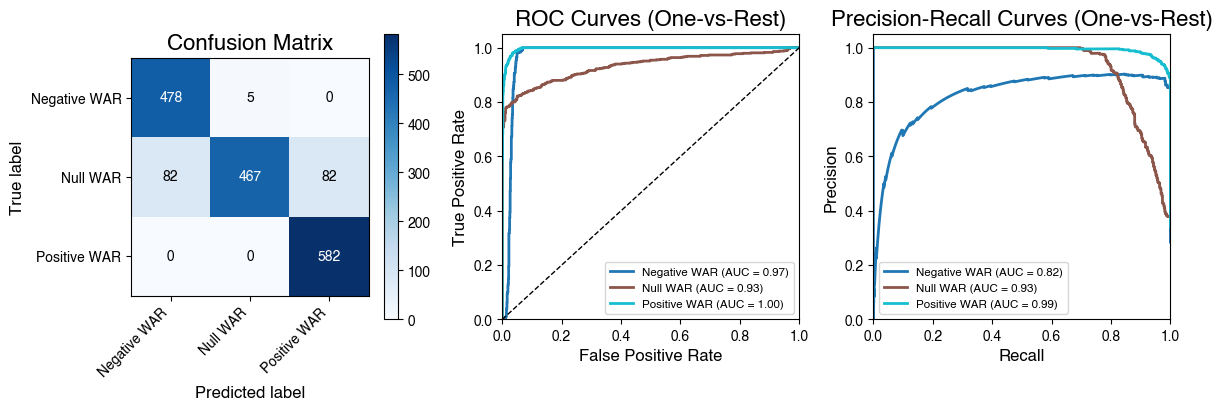

{'accuracy': np.float64(0.9003537735849056),
 'precision': np.float64(0.9119794716923338),
 'recall': np.float64(0.9003537735849056),
 'f1': np.float64(0.8966561163869763),
 'confusion_matrix': array([[478,   5,   0],
        [ 82, 467,  82],
        [  0,   0, 582]])}

In [161]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train_full_dev, y_train_full_dev)




evaluate_model(
    model=lda_model,
    X_test=X_test_full_dev,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  # Real class names
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(12, 4)
)






Accuracy: 0.6209
Precision: 0.4438
Recall: 0.6209
F1 Score: 0.5176


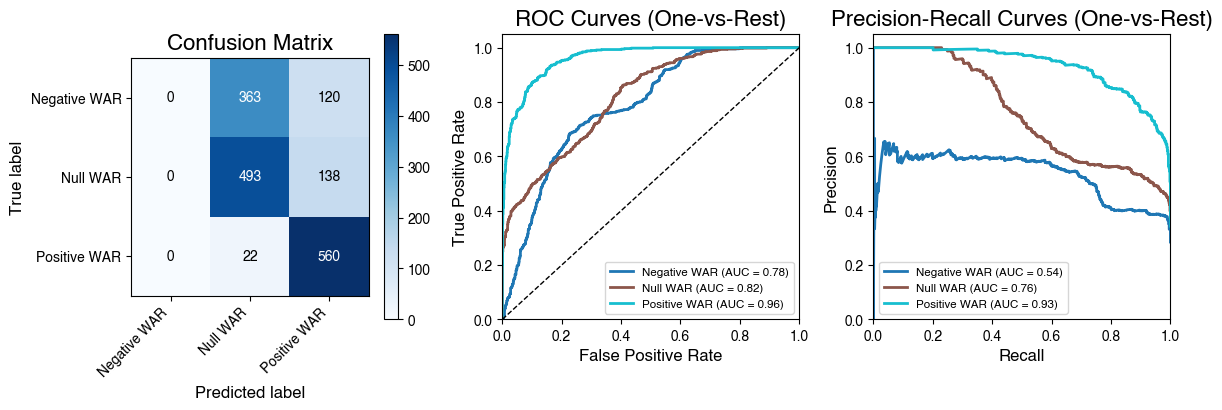

In [162]:
multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=0.1,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)




model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_full_dev_normalized, y_train_full_dev)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(12, 4),
    # average="weighted"
)

Accuracy: 0.9587
Precision: 0.9587
Recall: 0.9587
F1 Score: 0.9586


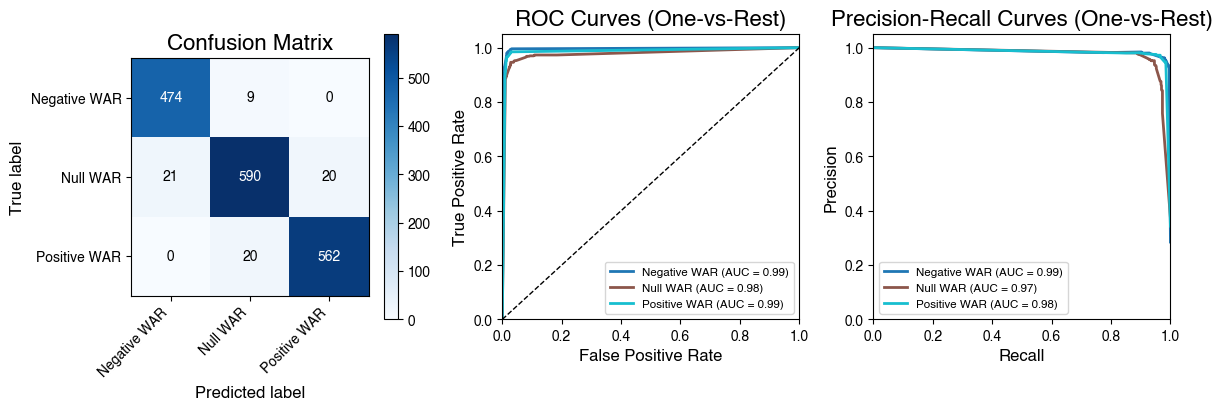

In [163]:
random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train_full_dev_normalized, y_train_full_dev)


result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(12, 4)
    # average="weighted"
)



